In [2]:
import os

import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
labels_file = 'Data/participants.tsv'
data_directory = 'cc_matrices/'

In [4]:
def read_matrix_from_file(file_path):
    with open(file_path, 'r') as file:
        content = file.readlines()
        matrix = []
        for line in content:
            values = line.rstrip().split(',')
            row = []
            for val in values:
                if val.strip():
                    try:
                        row.append(float(val))
                    except ValueError:
                        print(f"Warning: Non-numeric value '{val}' found. Skipping.")
            if row:
                matrix.append(row)
    return np.array(matrix)

In [7]:
participant_data = pd.read_csv(labels_file, sep='\t')
diagnosis_data = participant_data[['participant_id', 'diagnosis']]
unique_labels = ['CONTROL', 'ADHD', 'BIPOLAR', 'SCHZ']

labels_dict = dict(zip(diagnosis_data['participant_id'], diagnosis_data['diagnosis']))
labels_dict = {int(key.replace('sub-', '')): value for key, value in labels_dict.items()}
label_to_number = {label: i for i, label in enumerate(unique_labels)}
numerical_labels_dict = {participant_id: label_to_number[label] for participant_id, label in labels_dict.items()}

print("Unique Labels:", unique_labels)
print("Labels:\n", numerical_labels_dict)

Unique Labels: ['CONTROL', 'ADHD', 'BIPOLAR', 'SCHZ']
Labels:
 {10159: 0, 10171: 0, 10189: 0, 10193: 0, 10206: 0, 10217: 0, 10225: 0, 10227: 0, 10228: 0, 10235: 0, 10249: 0, 10269: 0, 10271: 0, 10273: 0, 10274: 0, 10280: 0, 10290: 0, 10292: 0, 10299: 0, 10304: 0, 10316: 0, 10321: 0, 10325: 0, 10329: 0, 10339: 0, 10340: 0, 10345: 0, 10347: 0, 10356: 0, 10361: 0, 10365: 0, 10376: 0, 10377: 0, 10388: 0, 10428: 0, 10429: 0, 10438: 0, 10440: 0, 10448: 0, 10455: 0, 10460: 0, 10471: 0, 10478: 0, 10487: 0, 10492: 0, 10501: 0, 10506: 0, 10517: 0, 10523: 0, 10524: 0, 10525: 0, 10527: 0, 10530: 0, 10557: 0, 10565: 0, 10570: 0, 10575: 0, 10624: 0, 10629: 0, 10631: 0, 10638: 0, 10668: 0, 10672: 0, 10674: 0, 10678: 0, 10680: 0, 10686: 0, 10692: 0, 10696: 0, 10697: 0, 10704: 0, 10707: 0, 10708: 0, 10719: 0, 10724: 0, 10746: 0, 10762: 0, 10779: 0, 10785: 0, 10788: 0, 10844: 0, 10855: 0, 10871: 0, 10877: 0, 10882: 0, 10891: 0, 10893: 0, 10912: 0, 10934: 0, 10940: 0, 10948: 0, 10949: 0, 10958: 0, 10963:

In [8]:
from collections import Counter

occurrences = Counter(labels_dict.values())
print("Whole dataset")
print(occurrences)

Whole dataset
Counter({'CONTROL': 130, 'SCHZ': 50, 'BIPOLAR': 49, 'ADHD': 43})


In [9]:
def read_data():
    data = []
    target = []
    for filename in os.listdir(data_directory):
        if filename.endswith('.txt'):
            file_id = int(filename.split('-')[-1].split('.')[0])
            if int(file_id) in labels_dict:
                file_path = os.path.join(data_directory, filename)
                matrix = read_matrix_from_file(file_path)
                data.append(matrix.flatten())
                label = labels_dict[file_id]
                if label == "CONTROL":
                    target.append(0)
                else:
                    target.append(1)
            else:
                raise Exception(f'{file_id} not in labels_dict')
    return data, target

In [10]:
data, target = read_data()

In [11]:
print("Current dataset")
for idx, d in enumerate(data):
    if len(d) != 13689:
        print(f'Deleted file: size:{len(d)}, idx:{idx}, label:{target[idx]}')
        del data[idx]
        del target[idx]

unique_values = set(target)
for val in unique_values:
    count = target.count(val)
    print(f"Count of {val}: {count}")
count_1 = target.count(0)
count_2 = target.count(1)

Current dataset
Deleted file: size:12544, idx:67, label:1
Deleted file: size:12544, idx:69, label:0
Deleted file: size:12769, idx:72, label:0
Count of 0: 29
Count of 1: 43


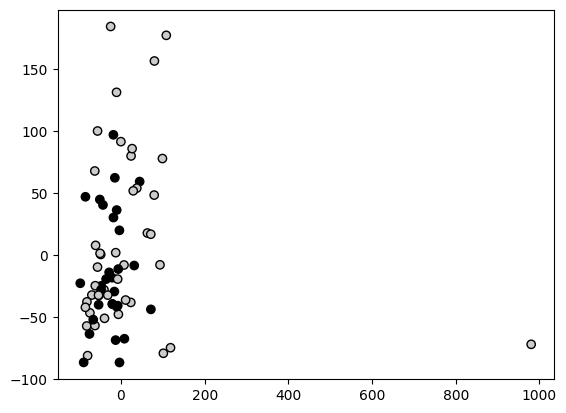

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

decompose = PCA(n_components=2)
decompose.fit(data)
data_2d = decompose.transform(data)

plt.scatter(data_2d[:, 0], data_2d[:, 1], c=target, cmap=plt.cm.nipy_spectral, edgecolor="k")

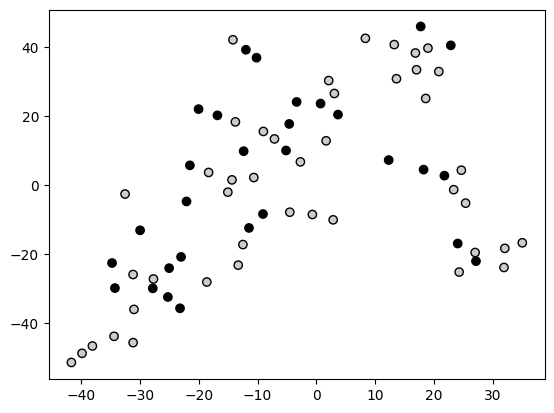

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
data_tsne = tsne.fit_transform(np.array(data))

plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=target, cmap=plt.cm.nipy_spectral, edgecolor="k")

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

57 57
15 15


In [22]:
svm_model = svm.SVC(kernel = 'rbf', class_weight = {0: count_2 / (count_1 + count_2), 1: count_1 / (count_1 + count_2)})
svm_model.fit(X_train, y_train)

SVC(class_weight={0: 0.5972222222222222, 1: 0.4027777777777778})

In [25]:
y_pred = svm_model.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7333333333333333
Precision: 1.0
Recall: 0.5555555555555556
F1 Score: 0.7142857142857143
Confusion Matrix:
 [[6 0]
 [4 5]]


In [73]:
classes = ["TN", "TP", "FP", "FN"]

def count(y_pred, y_test):
    result = 3 * (1 - (np.array(y_pred) == np.array(y_test))) + np.array(y_test)
    return result


def predict(svm_model, pca, X_test, y_test, do_tsne = False):
    data_2d = pca.transform(X_test)
    y_pred = svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)

    if pca:
        scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=count(y_pred, y_test), cmap=plt.cm.rainbow, edgecolor="k")
        plt.legend(handles=scatter.legend_elements()[0], labels=classes)
        plt.show()

    if do_tsne:
        tsne = TSNE(n_components=2, learning_rate='auto', perplexity=3)
        data_tsne = tsne.fit_transform(np.array(X_test))
        scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=count(y_pred, y_test), cmap=plt.cm.rainbow, edgecolor="k")
        plt.legend(handles=scatter.legend_elements()[0], labels=classes)
        plt.show()


TEST. kernel: linear, decision_function_shape: ovo
Accuracy: 0.5333333333333333
Precision: 0.5833333333333334
Recall: 0.7777777777777778
F1 Score: 0.6666666666666666
Confusion Matrix:
 [[1 5]
 [2 7]]


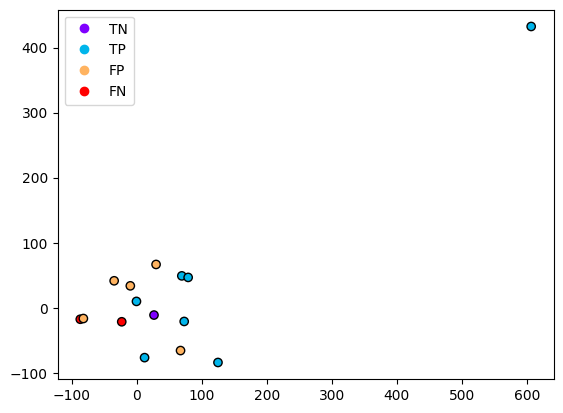

TRAIN. kernel: linear, decision_function_shape: ovo
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


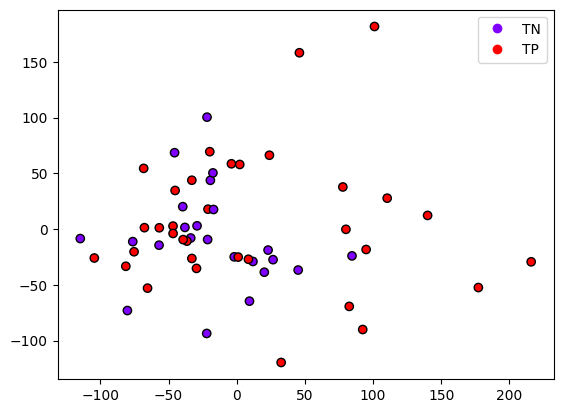

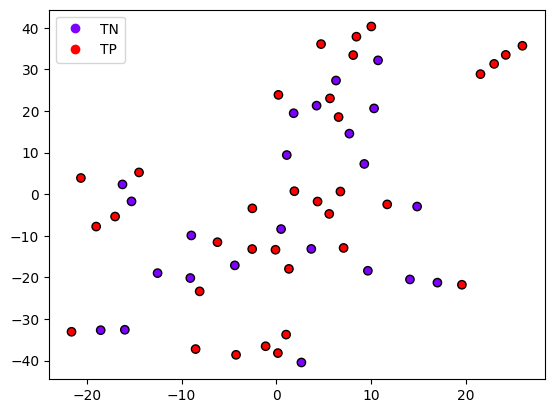


TEST. kernel: linear, decision_function_shape: ovr
Accuracy: 0.5333333333333333
Precision: 0.5833333333333334
Recall: 0.7777777777777778
F1 Score: 0.6666666666666666
Confusion Matrix:
 [[1 5]
 [2 7]]


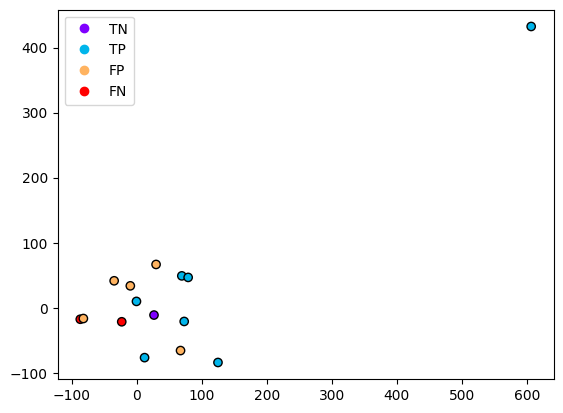

TRAIN. kernel: linear, decision_function_shape: ovr
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


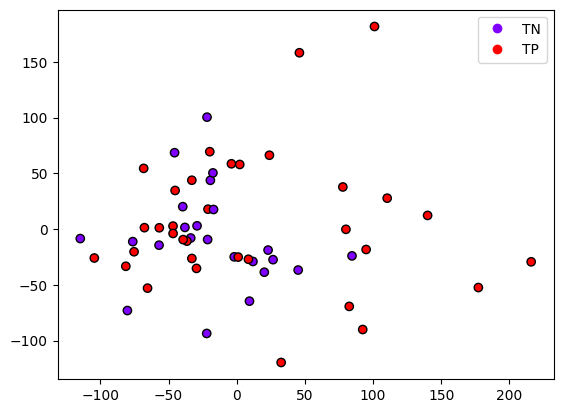

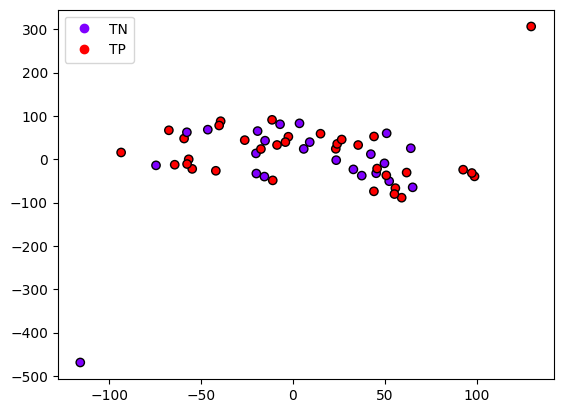


TEST kernel: poly, decision_function_shape: ovo, gamma: scale, degree: 2
Accuracy: 0.6
Precision: 0.7142857142857143
Recall: 0.5555555555555556
F1 Score: 0.6250000000000001
Confusion Matrix:
 [[4 2]
 [4 5]]


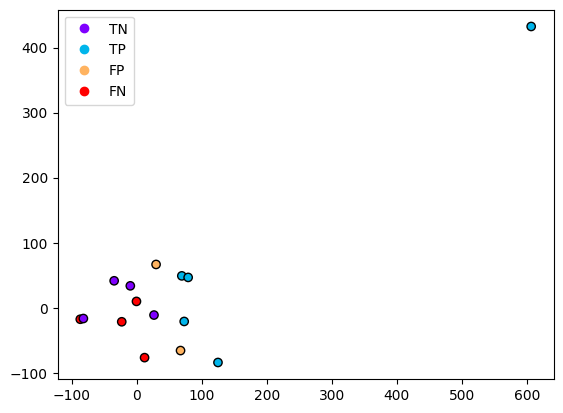

TRAIN kernel: poly, decision_function_shape: ovo, gamma: scale, degree: 2
Accuracy: 0.6140350877192983
Precision: 0.9285714285714286
Recall: 0.38235294117647056
F1 Score: 0.5416666666666667
Confusion Matrix:
 [[22  1]
 [21 13]]


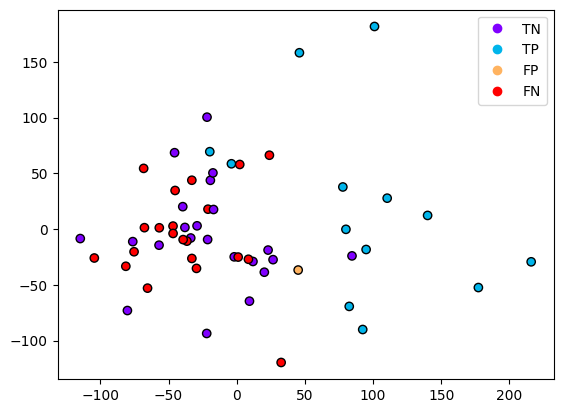

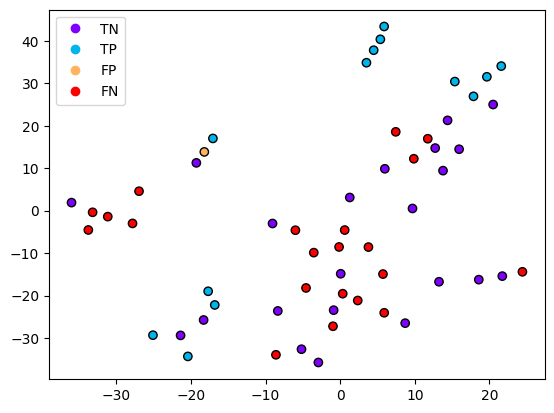


TEST kernel: poly, decision_function_shape: ovo, gamma: scale, degree: 3
Accuracy: 0.6666666666666666
Precision: 0.8333333333333334
Recall: 0.5555555555555556
F1 Score: 0.6666666666666667
Confusion Matrix:
 [[5 1]
 [4 5]]


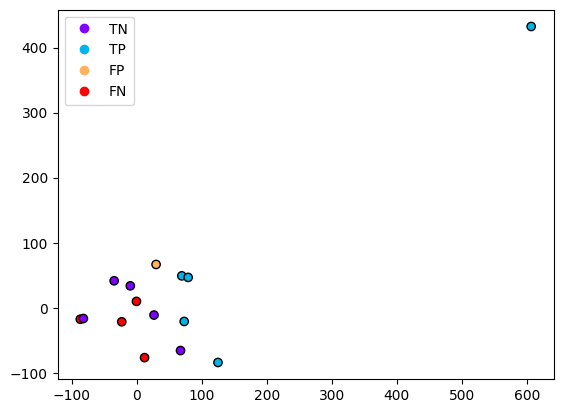

TRAIN kernel: poly, decision_function_shape: ovo, gamma: scale, degree: 3
Accuracy: 0.6140350877192983
Precision: 1.0
Recall: 0.35294117647058826
F1 Score: 0.5217391304347826
Confusion Matrix:
 [[23  0]
 [22 12]]


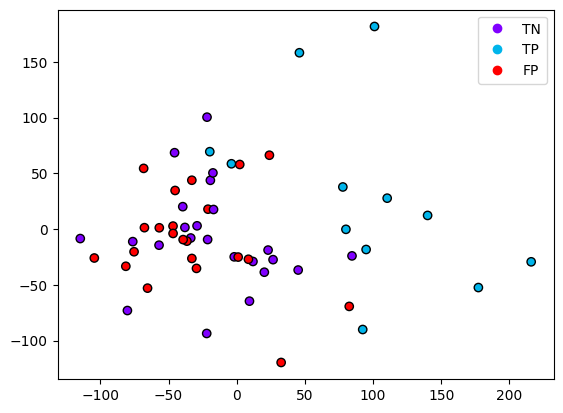

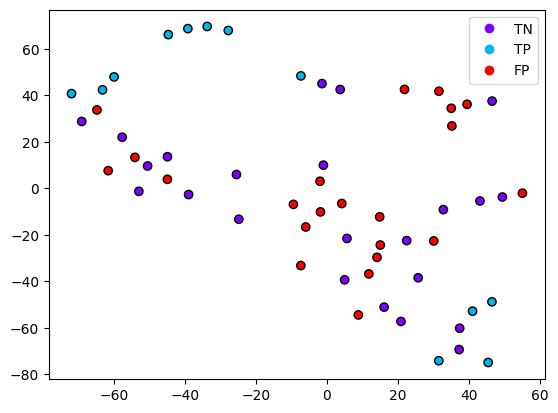


TEST kernel: poly, decision_function_shape: ovo, gamma: scale, degree: 5
Accuracy: 0.7333333333333333
Precision: 1.0
Recall: 0.5555555555555556
F1 Score: 0.7142857142857143
Confusion Matrix:
 [[6 0]
 [4 5]]


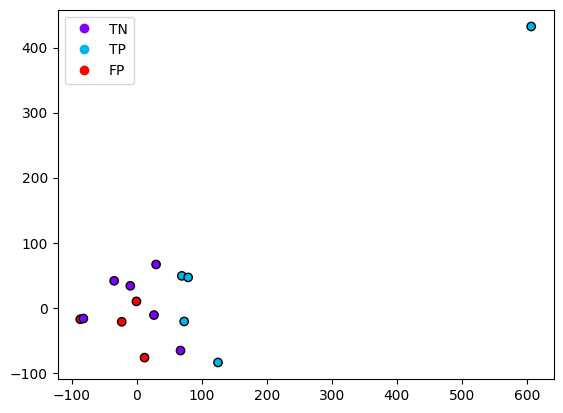

TRAIN kernel: poly, decision_function_shape: ovo, gamma: scale, degree: 5
Accuracy: 0.631578947368421
Precision: 1.0
Recall: 0.38235294117647056
F1 Score: 0.5531914893617021
Confusion Matrix:
 [[23  0]
 [21 13]]


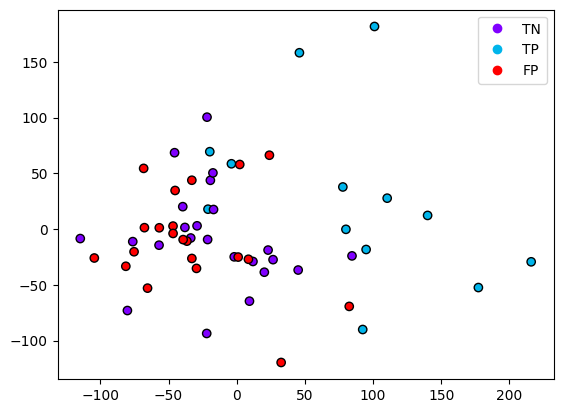

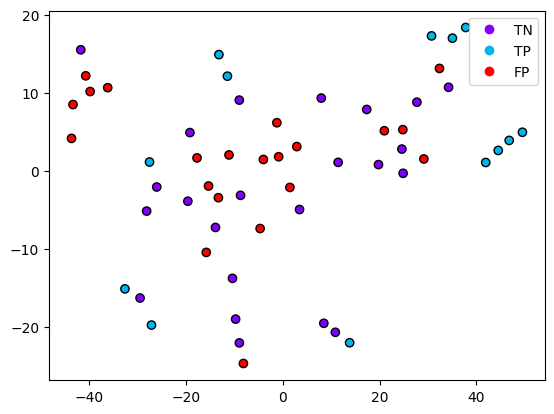


TEST kernel: poly, decision_function_shape: ovo, gamma: scale, degree: 10
Accuracy: 0.7333333333333333
Precision: 1.0
Recall: 0.5555555555555556
F1 Score: 0.7142857142857143
Confusion Matrix:
 [[6 0]
 [4 5]]


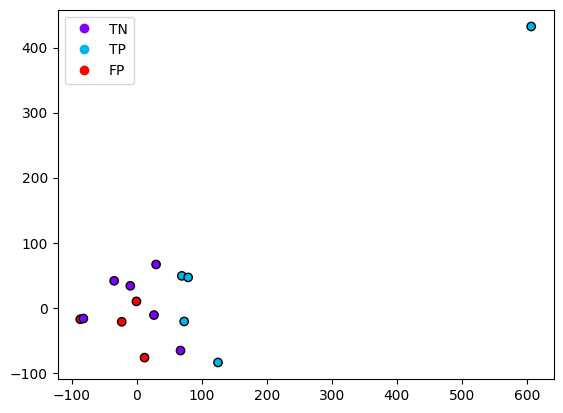

TRAIN kernel: poly, decision_function_shape: ovo, gamma: scale, degree: 10
Accuracy: 0.6842105263157895
Precision: 1.0
Recall: 0.47058823529411764
F1 Score: 0.6399999999999999
Confusion Matrix:
 [[23  0]
 [18 16]]


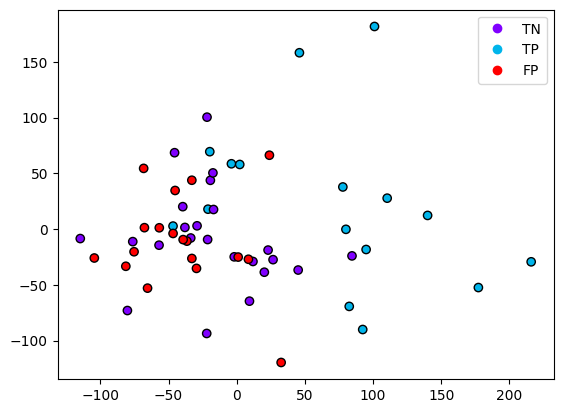

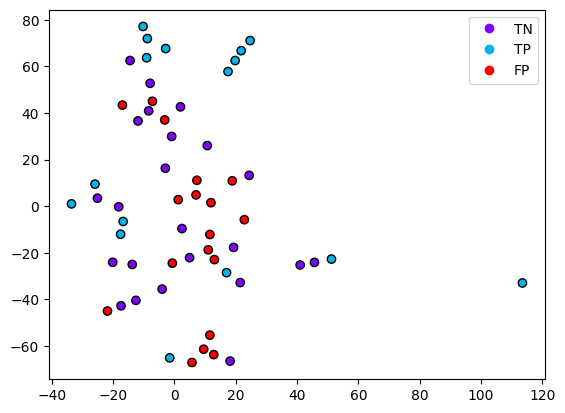


TEST kernel: poly, decision_function_shape: ovo, gamma: 0.1, degree: 2
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


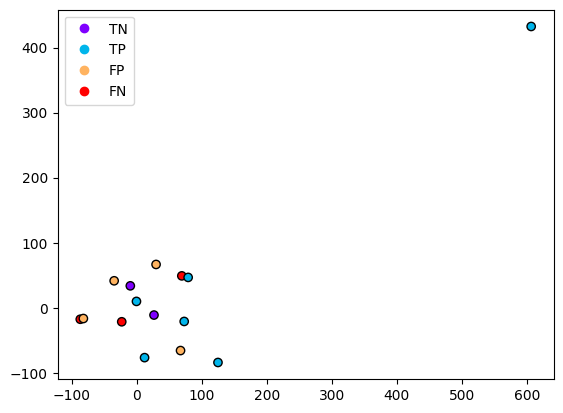

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 0.1, degree: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


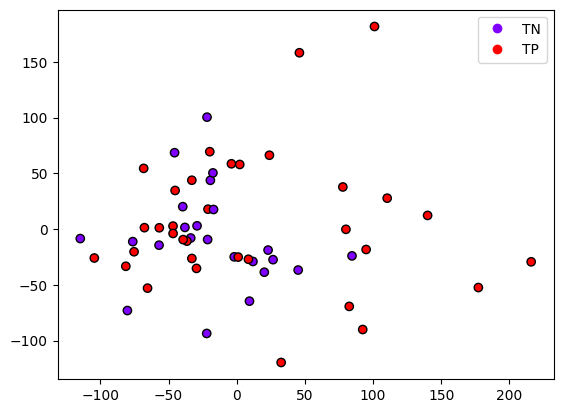

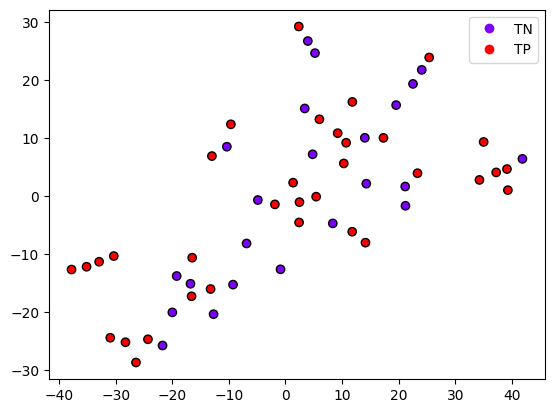


TEST kernel: poly, decision_function_shape: ovo, gamma: 0.1, degree: 3
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


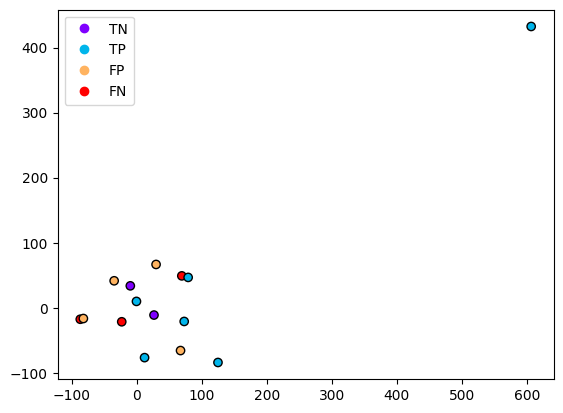

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 0.1, degree: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


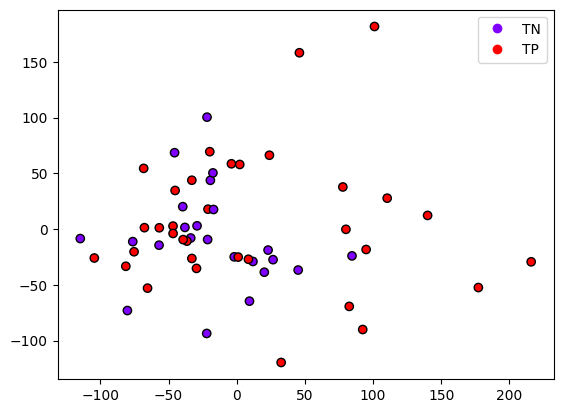

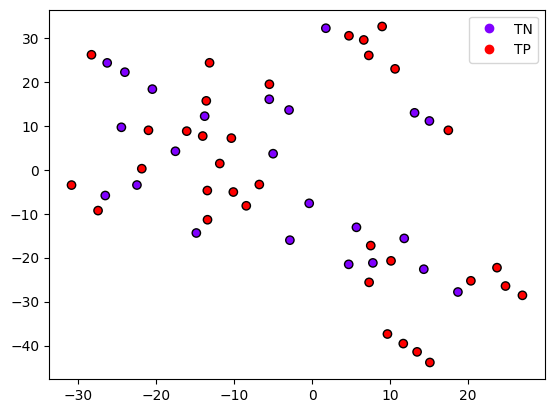


TEST kernel: poly, decision_function_shape: ovo, gamma: 0.1, degree: 5
Accuracy: 0.4666666666666667
Precision: 0.5555555555555556
Recall: 0.5555555555555556
F1 Score: 0.5555555555555556
Confusion Matrix:
 [[2 4]
 [4 5]]


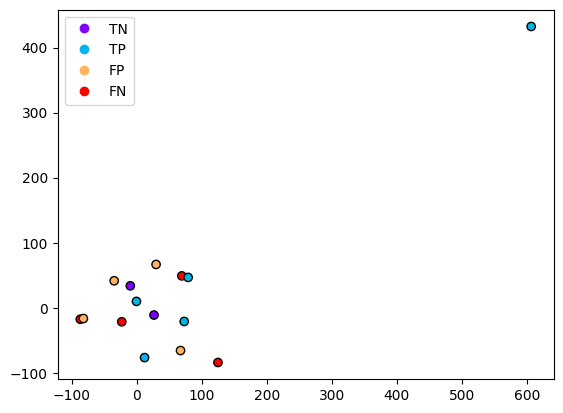

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 0.1, degree: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


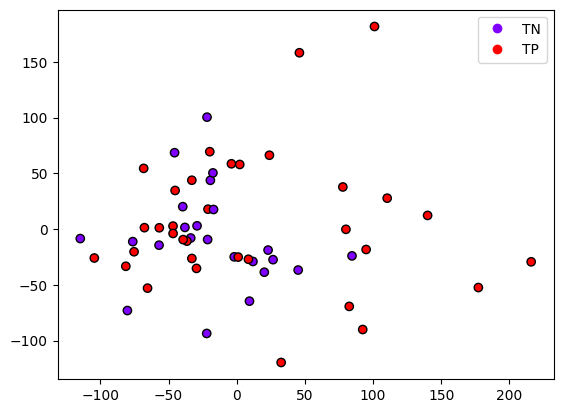

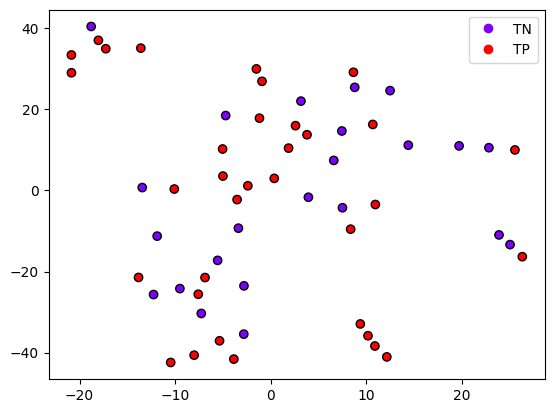


TEST kernel: poly, decision_function_shape: ovo, gamma: 0.1, degree: 10
Incorrect parameters.

TEST kernel: poly, decision_function_shape: ovo, gamma: 0.5, degree: 2
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


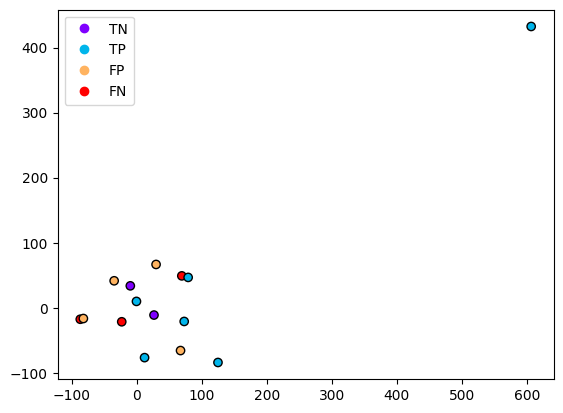

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 0.5, degree: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


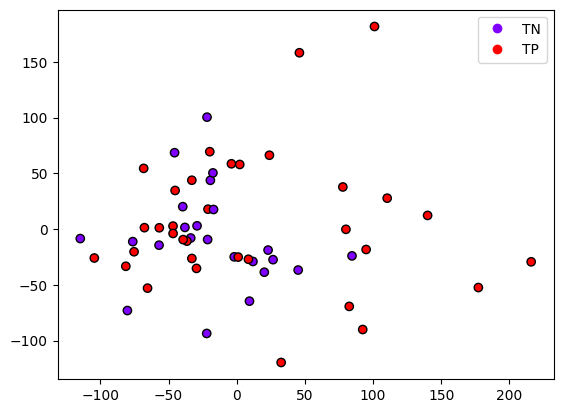

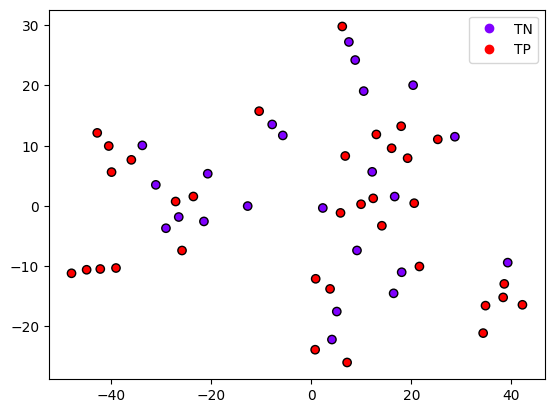


TEST kernel: poly, decision_function_shape: ovo, gamma: 0.5, degree: 3
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


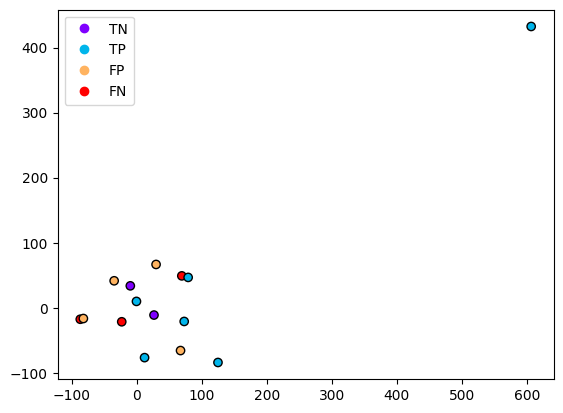

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 0.5, degree: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


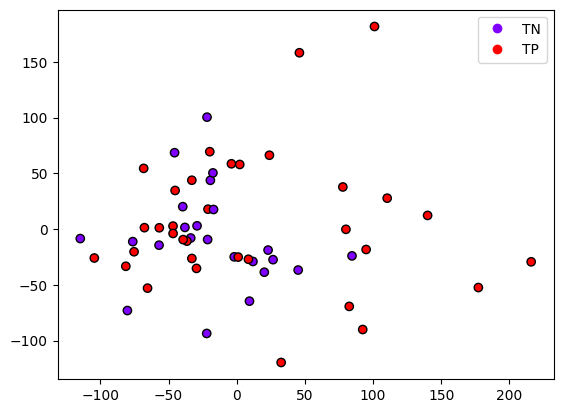

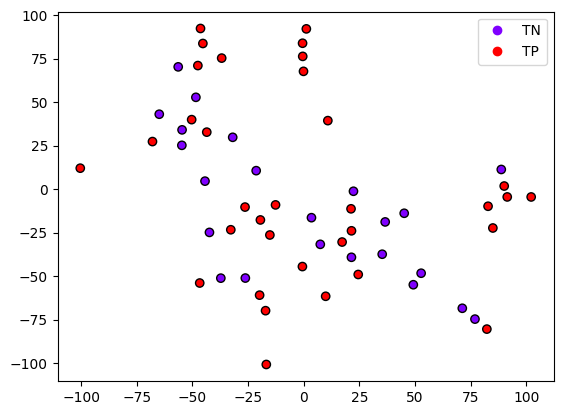


TEST kernel: poly, decision_function_shape: ovo, gamma: 0.5, degree: 5
Accuracy: 0.4666666666666667
Precision: 0.5555555555555556
Recall: 0.5555555555555556
F1 Score: 0.5555555555555556
Confusion Matrix:
 [[2 4]
 [4 5]]


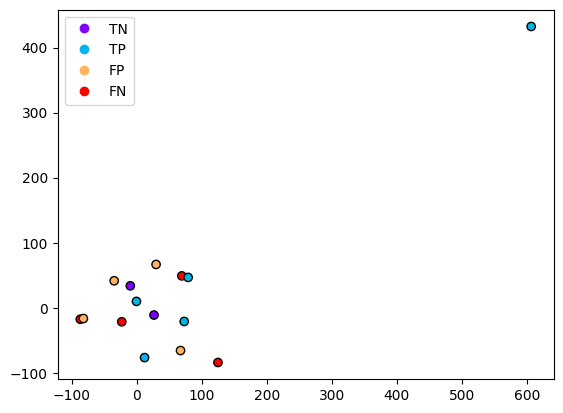

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 0.5, degree: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


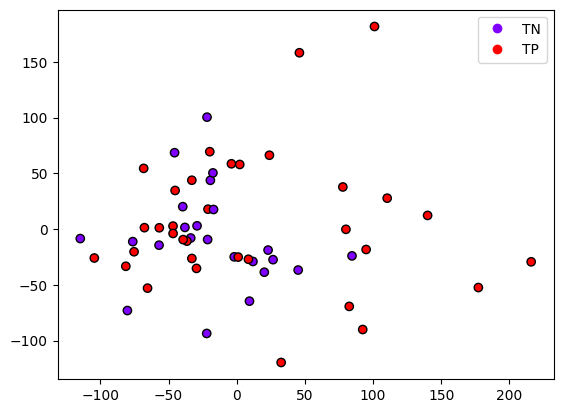

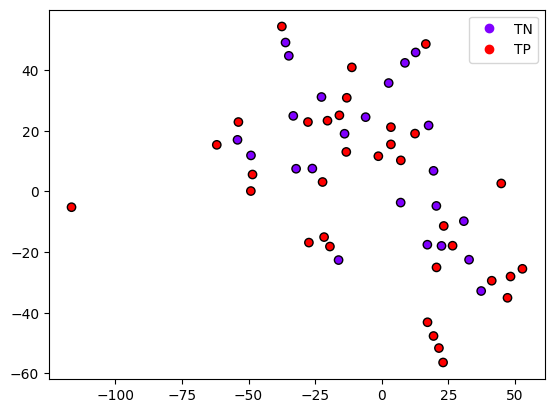


TEST kernel: poly, decision_function_shape: ovo, gamma: 0.5, degree: 10
Incorrect parameters.

TEST kernel: poly, decision_function_shape: ovo, gamma: 1.0, degree: 2
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


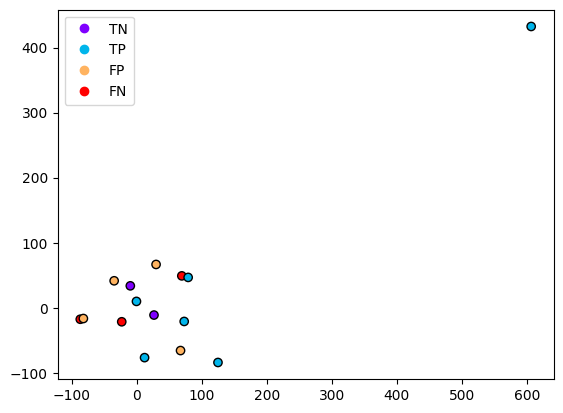

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 1.0, degree: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


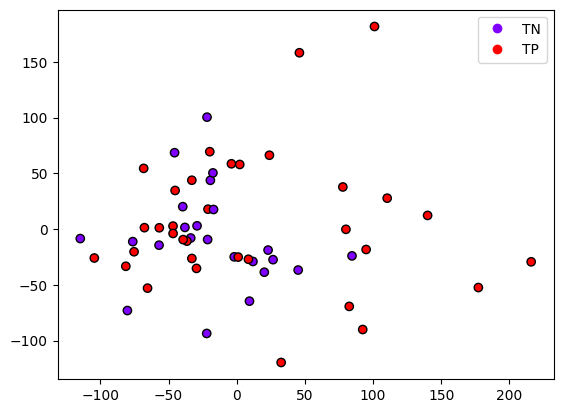

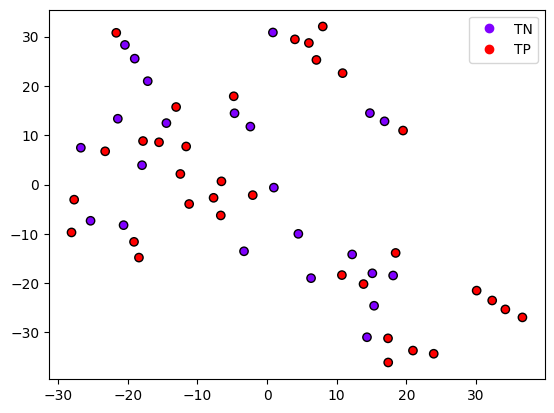


TEST kernel: poly, decision_function_shape: ovo, gamma: 1.0, degree: 3
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


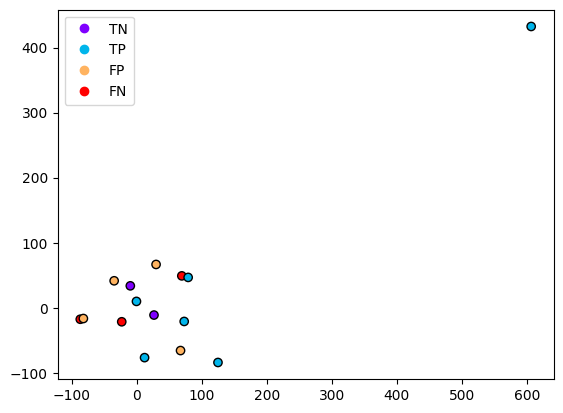

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 1.0, degree: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


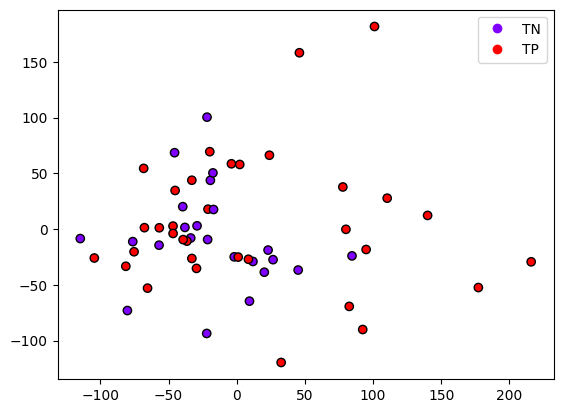

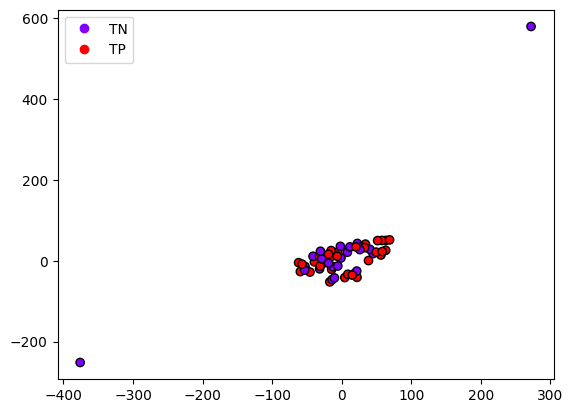


TEST kernel: poly, decision_function_shape: ovo, gamma: 1.0, degree: 5
Accuracy: 0.4666666666666667
Precision: 0.5555555555555556
Recall: 0.5555555555555556
F1 Score: 0.5555555555555556
Confusion Matrix:
 [[2 4]
 [4 5]]


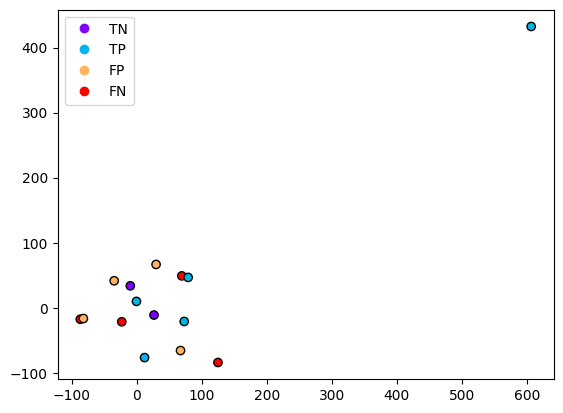

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 1.0, degree: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


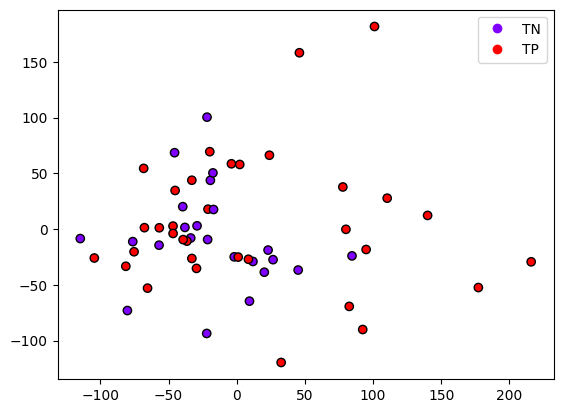

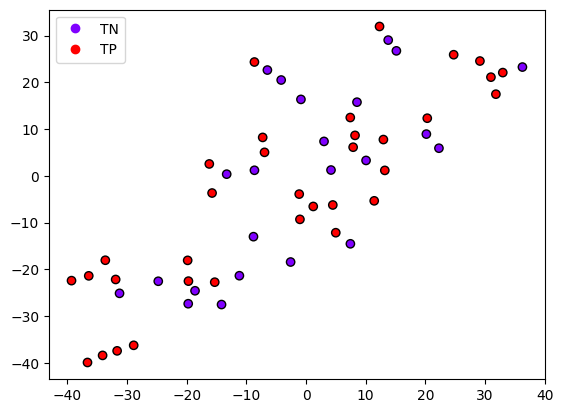


TEST kernel: poly, decision_function_shape: ovo, gamma: 1.0, degree: 10
Incorrect parameters.

TEST kernel: poly, decision_function_shape: ovo, gamma: 2.0, degree: 2
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


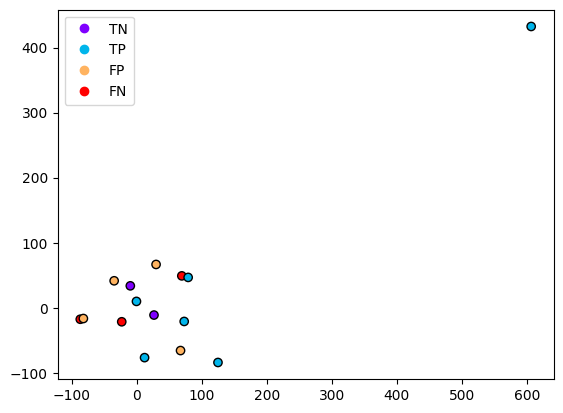

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 2.0, degree: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


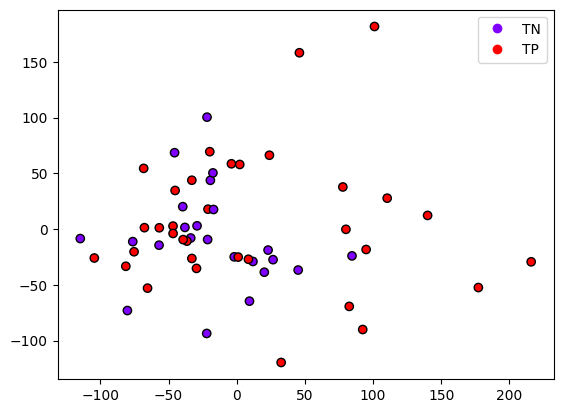

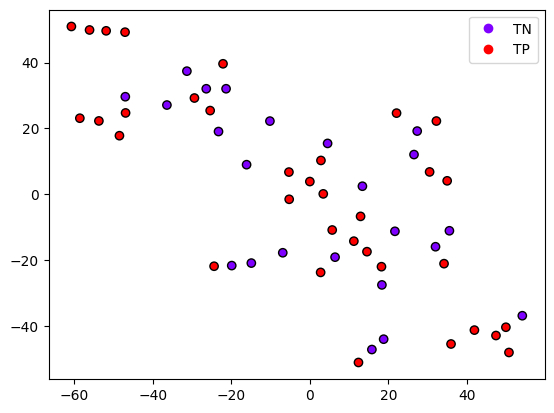


TEST kernel: poly, decision_function_shape: ovo, gamma: 2.0, degree: 3
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


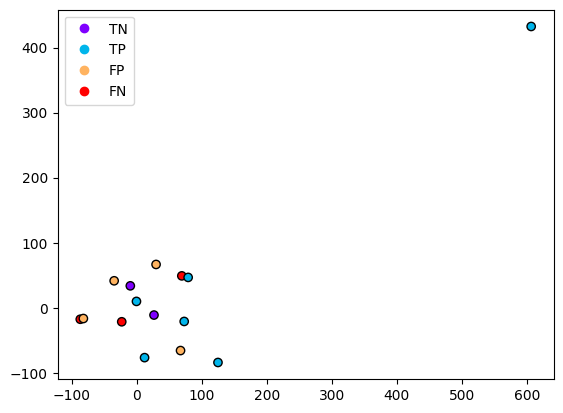

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 2.0, degree: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


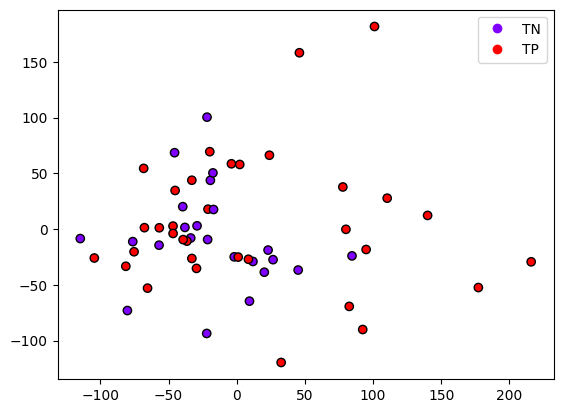

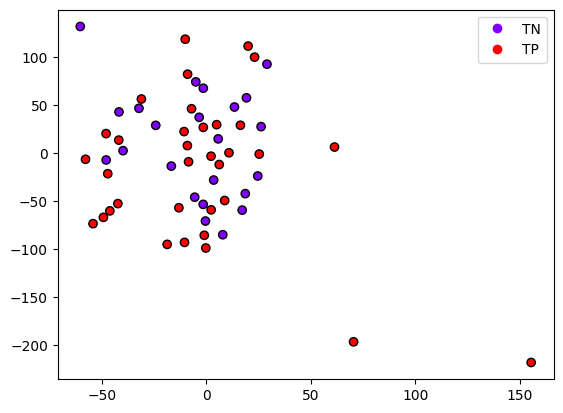


TEST kernel: poly, decision_function_shape: ovo, gamma: 2.0, degree: 5
Accuracy: 0.4666666666666667
Precision: 0.5555555555555556
Recall: 0.5555555555555556
F1 Score: 0.5555555555555556
Confusion Matrix:
 [[2 4]
 [4 5]]


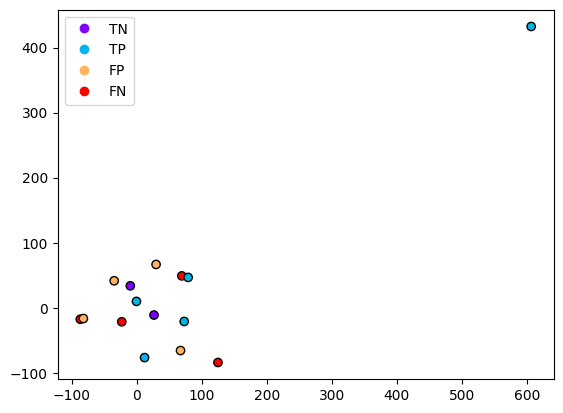

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 2.0, degree: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


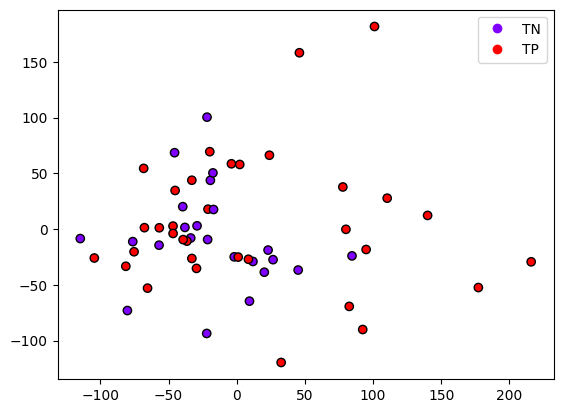

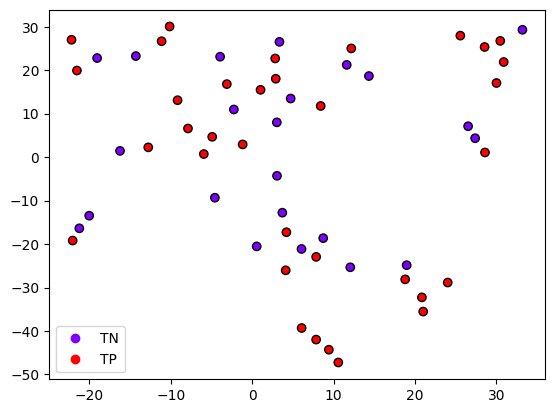


TEST kernel: poly, decision_function_shape: ovo, gamma: 2.0, degree: 10
Incorrect parameters.

TEST kernel: poly, decision_function_shape: ovo, gamma: 10.0, degree: 2
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


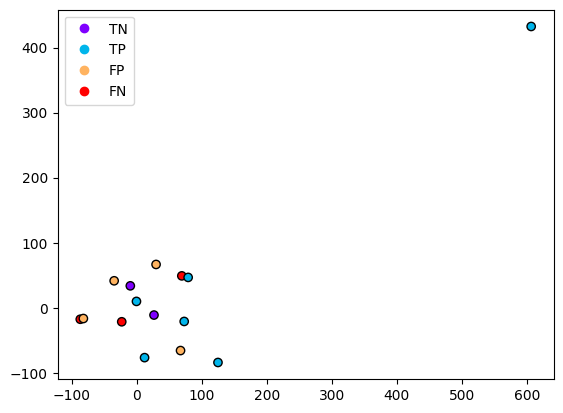

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 10.0, degree: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


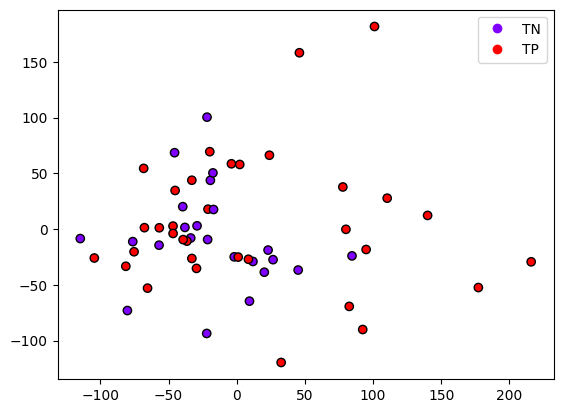

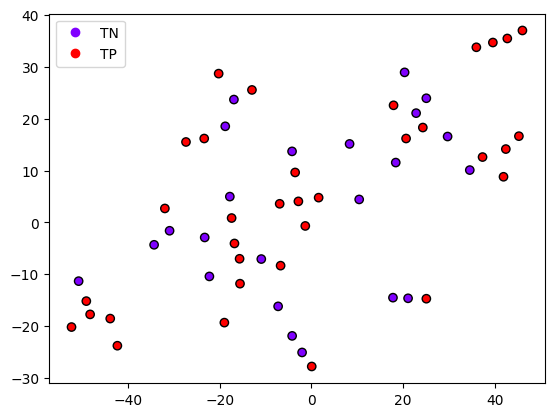


TEST kernel: poly, decision_function_shape: ovo, gamma: 10.0, degree: 3
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


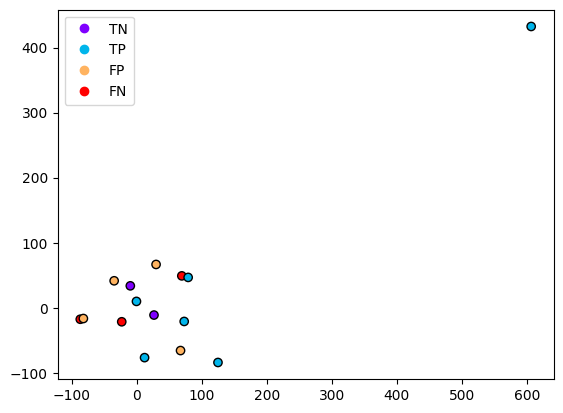

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 10.0, degree: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


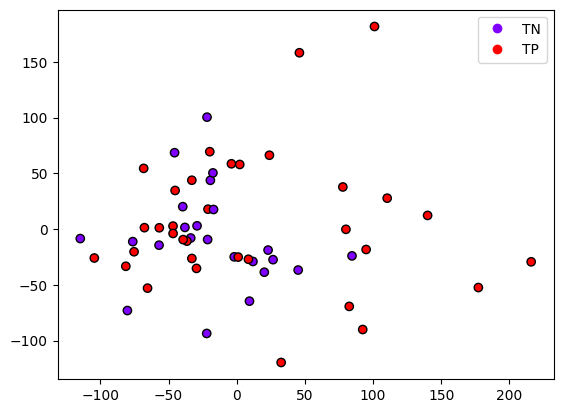

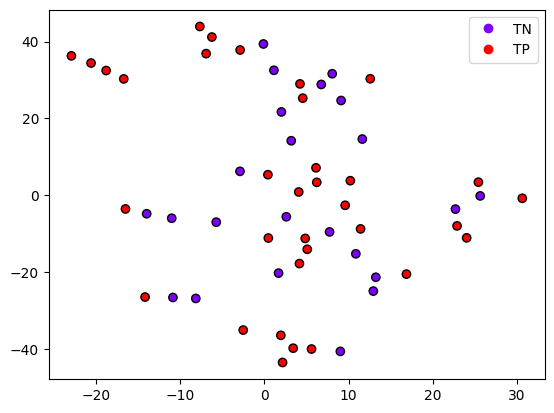


TEST kernel: poly, decision_function_shape: ovo, gamma: 10.0, degree: 5
Accuracy: 0.4666666666666667
Precision: 0.5555555555555556
Recall: 0.5555555555555556
F1 Score: 0.5555555555555556
Confusion Matrix:
 [[2 4]
 [4 5]]


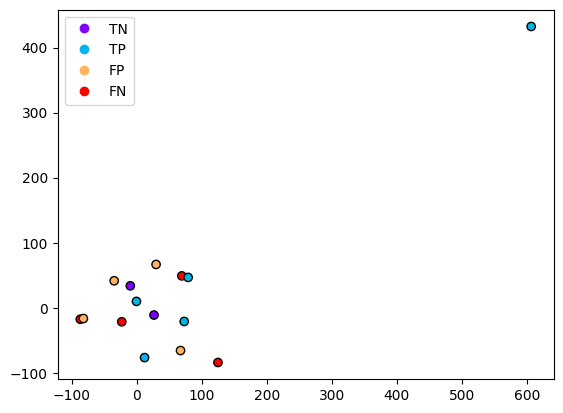

TRAIN kernel: poly, decision_function_shape: ovo, gamma: 10.0, degree: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


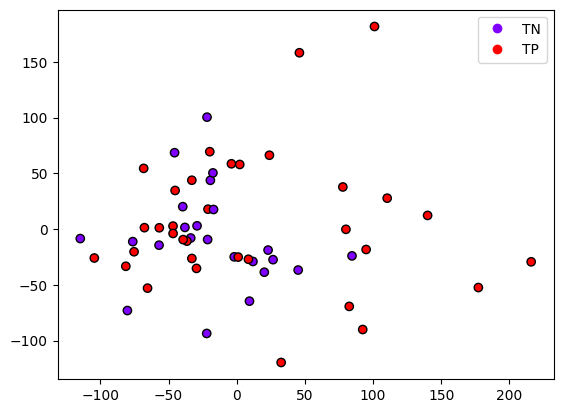

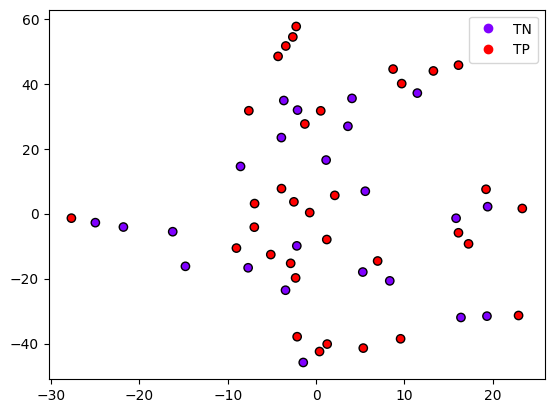


TEST kernel: poly, decision_function_shape: ovo, gamma: 10.0, degree: 10
Incorrect parameters.

TEST kernel: poly, decision_function_shape: ovr, gamma: scale, degree: 2
Accuracy: 0.6
Precision: 0.7142857142857143
Recall: 0.5555555555555556
F1 Score: 0.6250000000000001
Confusion Matrix:
 [[4 2]
 [4 5]]


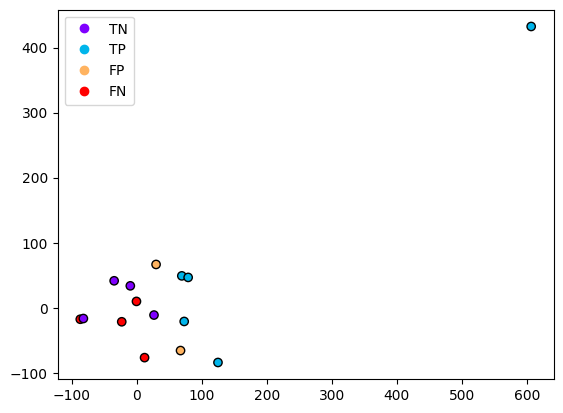

TRAIN kernel: poly, decision_function_shape: ovr, gamma: scale, degree: 2
Accuracy: 0.6140350877192983
Precision: 0.9285714285714286
Recall: 0.38235294117647056
F1 Score: 0.5416666666666667
Confusion Matrix:
 [[22  1]
 [21 13]]


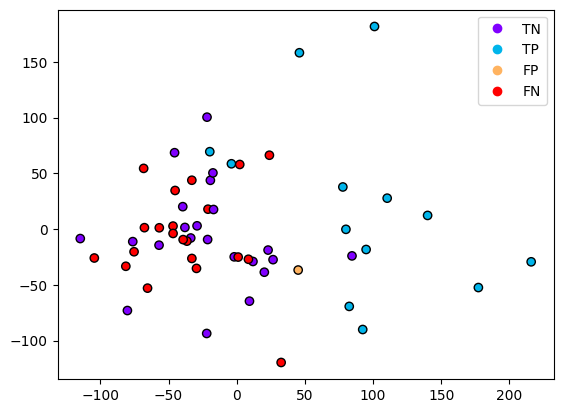

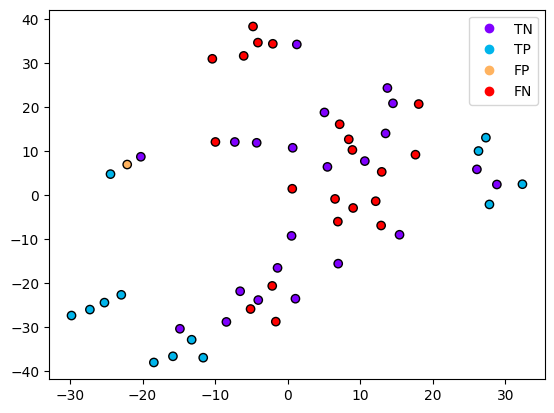


TEST kernel: poly, decision_function_shape: ovr, gamma: scale, degree: 3
Accuracy: 0.6666666666666666
Precision: 0.8333333333333334
Recall: 0.5555555555555556
F1 Score: 0.6666666666666667
Confusion Matrix:
 [[5 1]
 [4 5]]


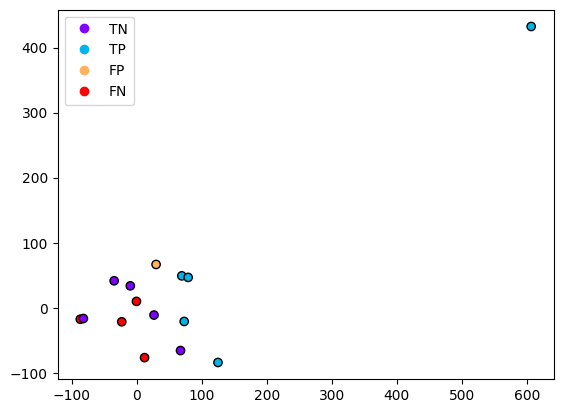

TRAIN kernel: poly, decision_function_shape: ovr, gamma: scale, degree: 3
Accuracy: 0.6140350877192983
Precision: 1.0
Recall: 0.35294117647058826
F1 Score: 0.5217391304347826
Confusion Matrix:
 [[23  0]
 [22 12]]


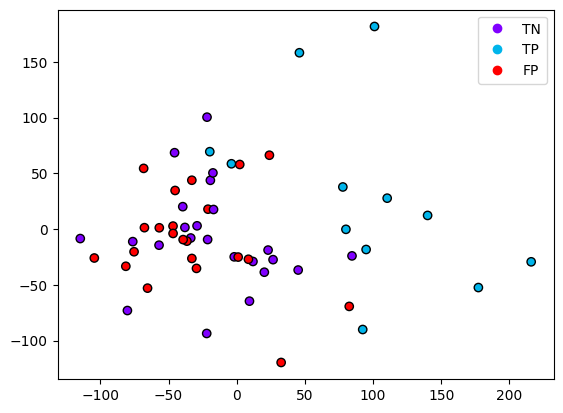

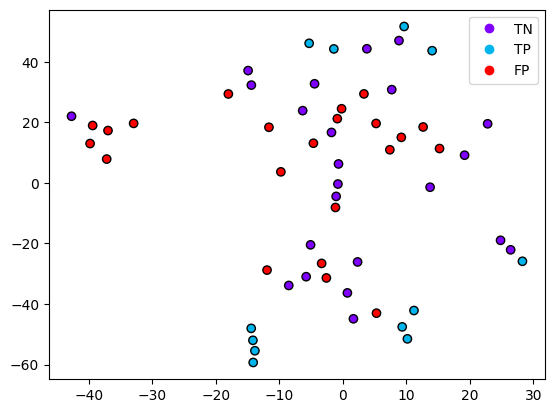


TEST kernel: poly, decision_function_shape: ovr, gamma: scale, degree: 5
Accuracy: 0.7333333333333333
Precision: 1.0
Recall: 0.5555555555555556
F1 Score: 0.7142857142857143
Confusion Matrix:
 [[6 0]
 [4 5]]


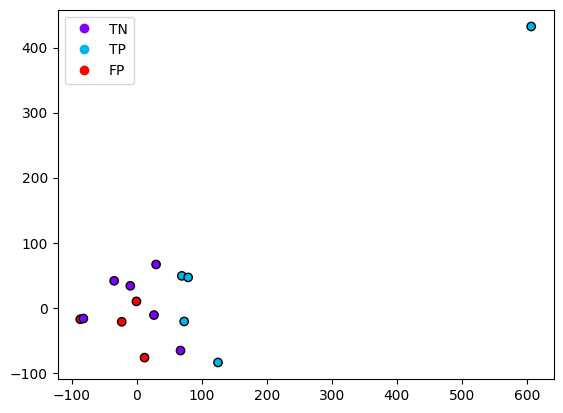

TRAIN kernel: poly, decision_function_shape: ovr, gamma: scale, degree: 5
Accuracy: 0.631578947368421
Precision: 1.0
Recall: 0.38235294117647056
F1 Score: 0.5531914893617021
Confusion Matrix:
 [[23  0]
 [21 13]]


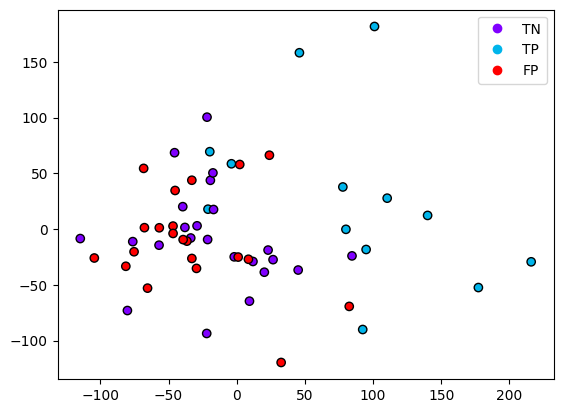

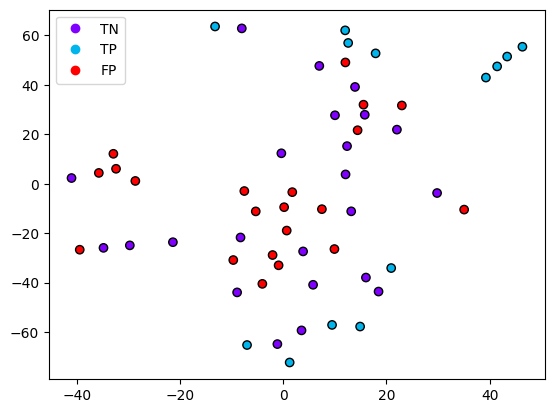


TEST kernel: poly, decision_function_shape: ovr, gamma: scale, degree: 10
Accuracy: 0.7333333333333333
Precision: 1.0
Recall: 0.5555555555555556
F1 Score: 0.7142857142857143
Confusion Matrix:
 [[6 0]
 [4 5]]


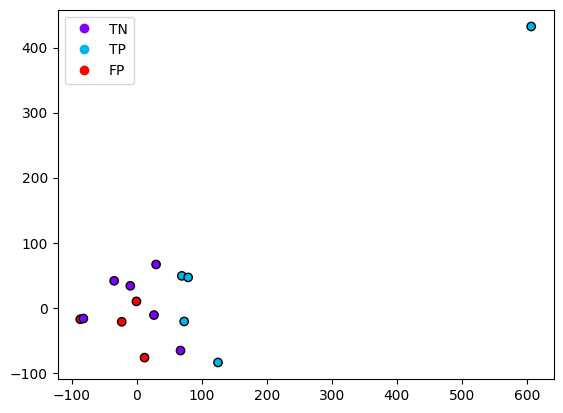

TRAIN kernel: poly, decision_function_shape: ovr, gamma: scale, degree: 10
Accuracy: 0.6842105263157895
Precision: 1.0
Recall: 0.47058823529411764
F1 Score: 0.6399999999999999
Confusion Matrix:
 [[23  0]
 [18 16]]


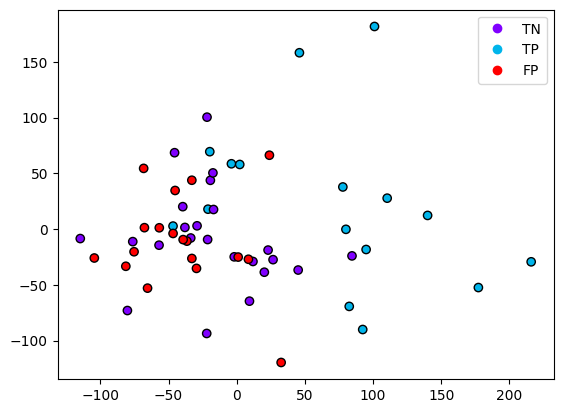

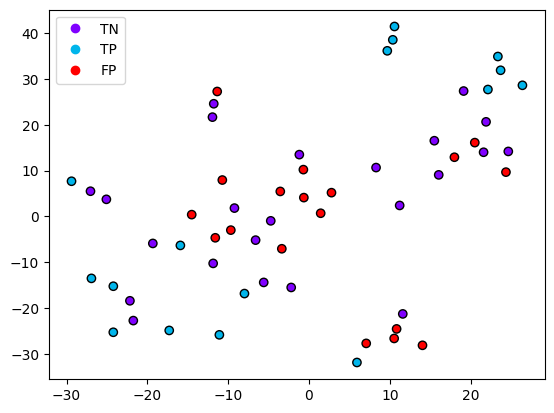


TEST kernel: poly, decision_function_shape: ovr, gamma: 0.1, degree: 2
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


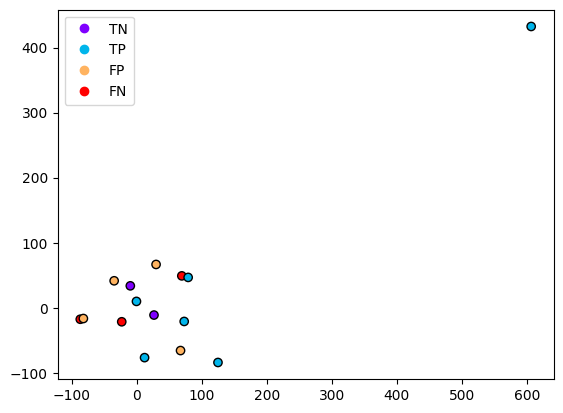

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 0.1, degree: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


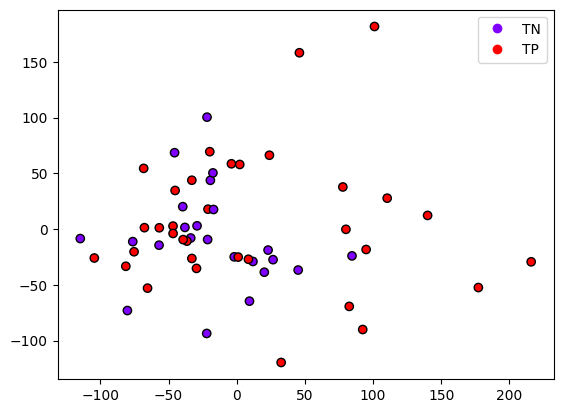

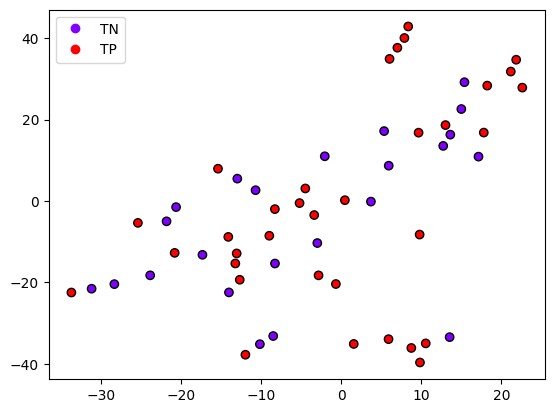


TEST kernel: poly, decision_function_shape: ovr, gamma: 0.1, degree: 3
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


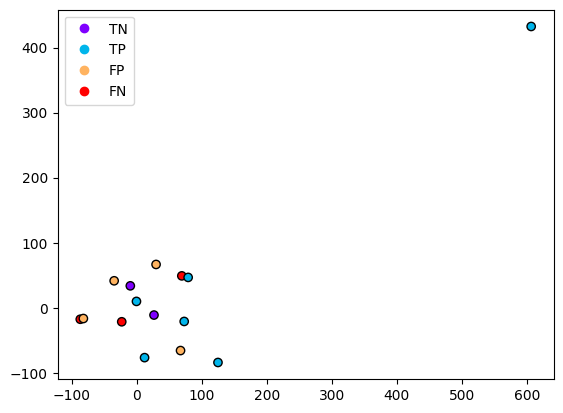

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 0.1, degree: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


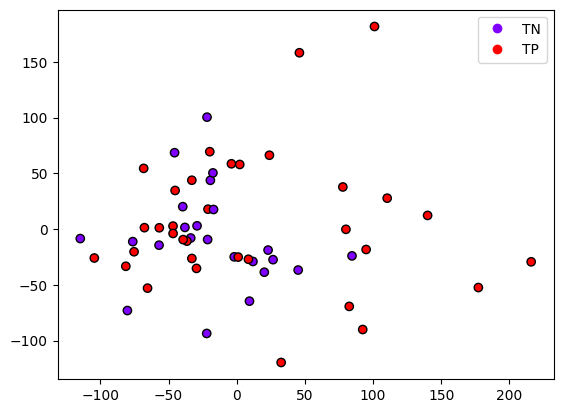

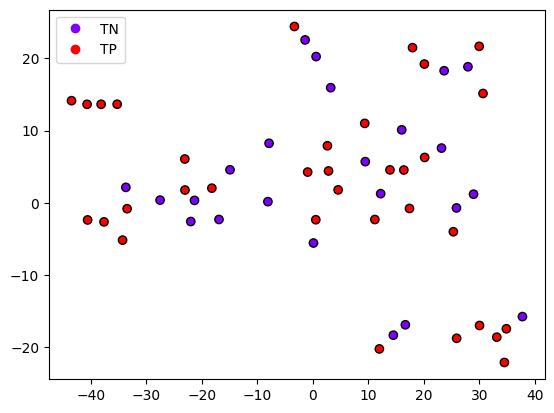


TEST kernel: poly, decision_function_shape: ovr, gamma: 0.1, degree: 5
Accuracy: 0.4666666666666667
Precision: 0.5555555555555556
Recall: 0.5555555555555556
F1 Score: 0.5555555555555556
Confusion Matrix:
 [[2 4]
 [4 5]]


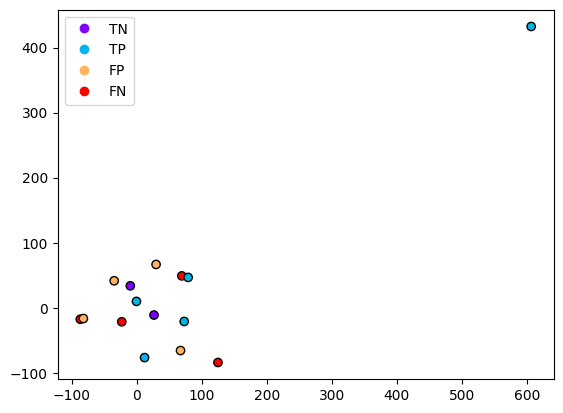

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 0.1, degree: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


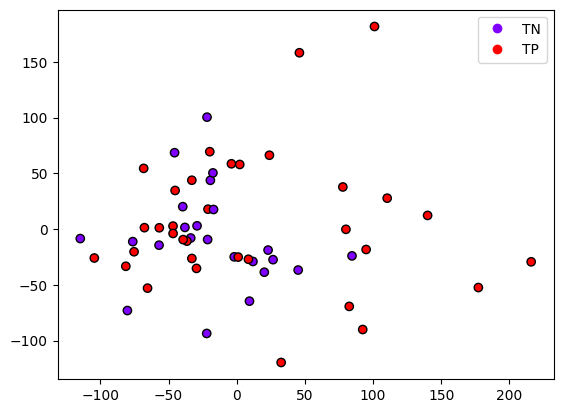

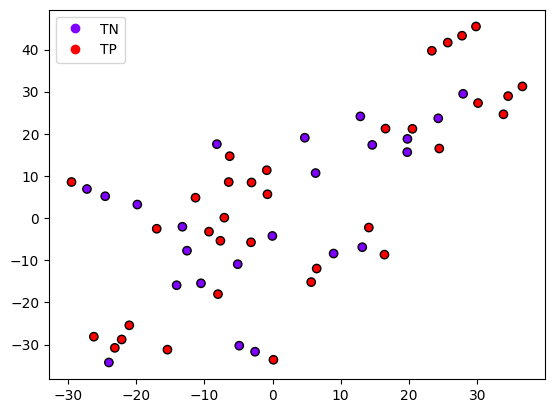


TEST kernel: poly, decision_function_shape: ovr, gamma: 0.1, degree: 10
Incorrect parameters.

TEST kernel: poly, decision_function_shape: ovr, gamma: 0.5, degree: 2
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


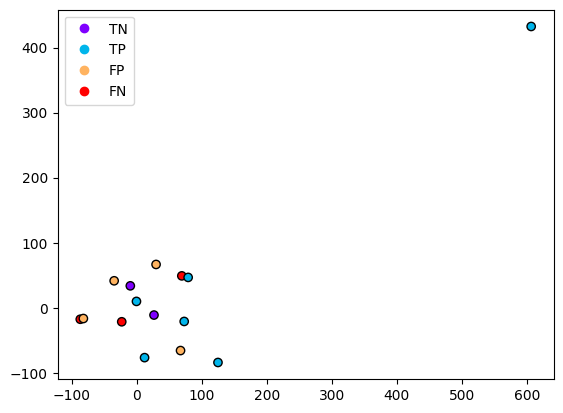

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 0.5, degree: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


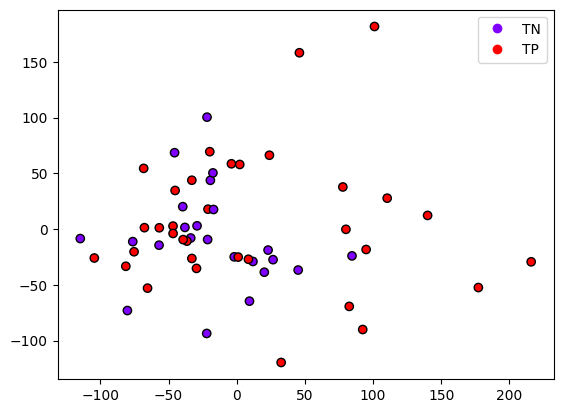

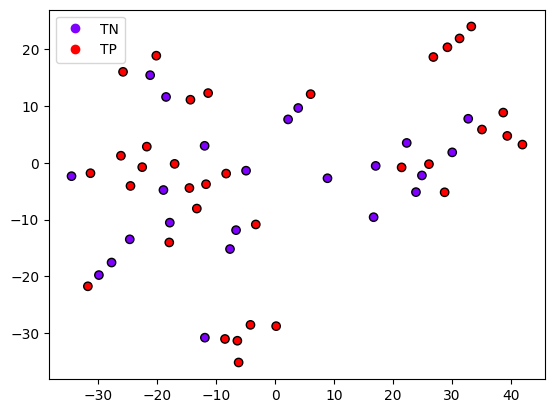


TEST kernel: poly, decision_function_shape: ovr, gamma: 0.5, degree: 3
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


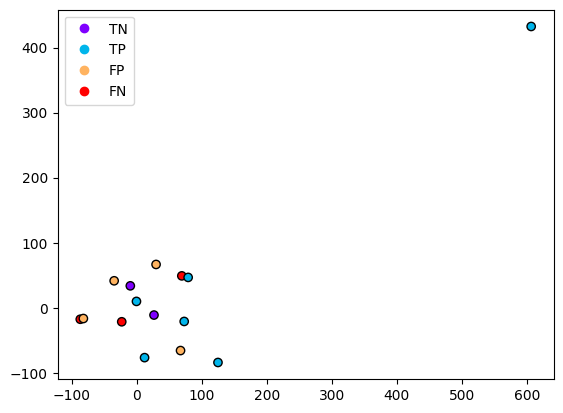

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 0.5, degree: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


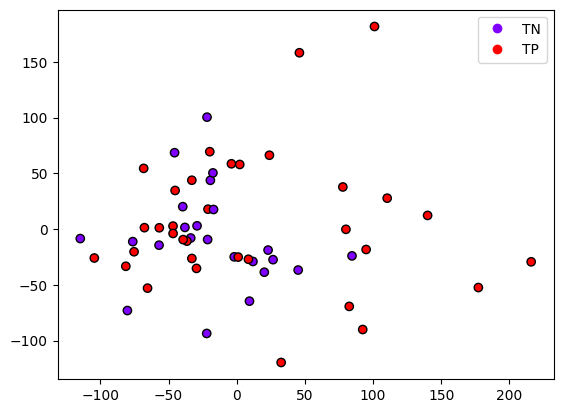

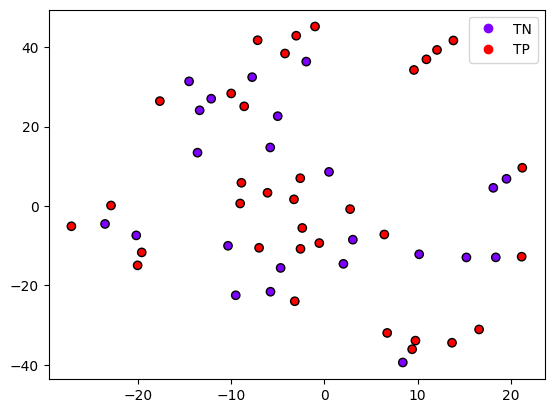


TEST kernel: poly, decision_function_shape: ovr, gamma: 0.5, degree: 5
Accuracy: 0.4666666666666667
Precision: 0.5555555555555556
Recall: 0.5555555555555556
F1 Score: 0.5555555555555556
Confusion Matrix:
 [[2 4]
 [4 5]]


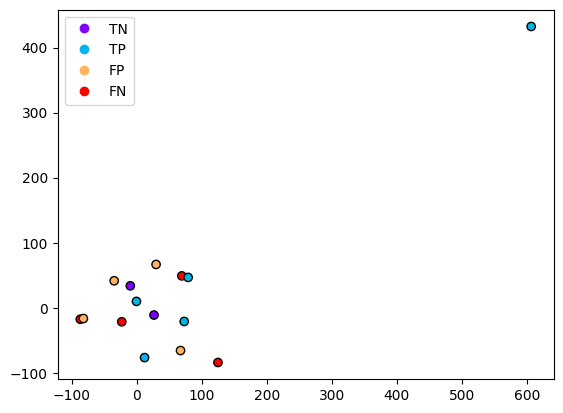

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 0.5, degree: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


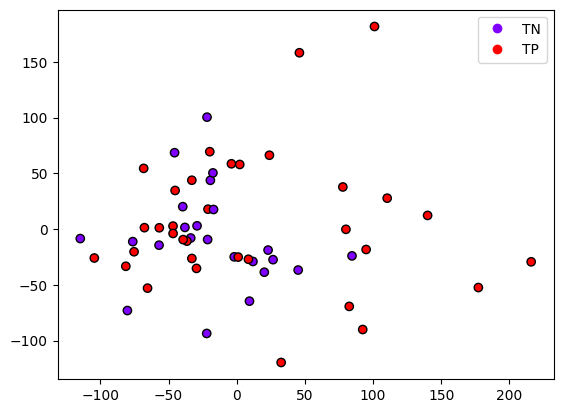

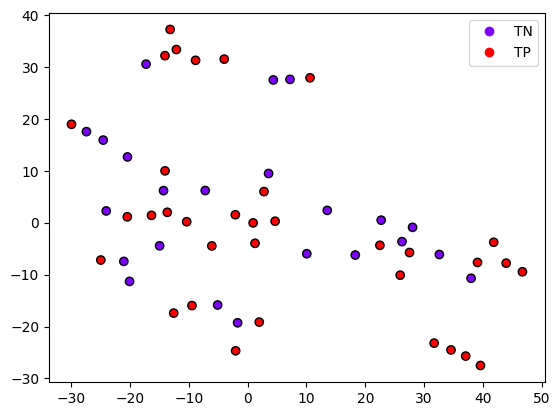


TEST kernel: poly, decision_function_shape: ovr, gamma: 0.5, degree: 10
Incorrect parameters.

TEST kernel: poly, decision_function_shape: ovr, gamma: 1.0, degree: 2
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


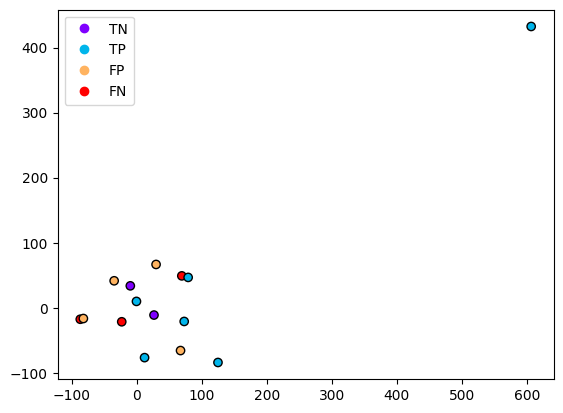

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 1.0, degree: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


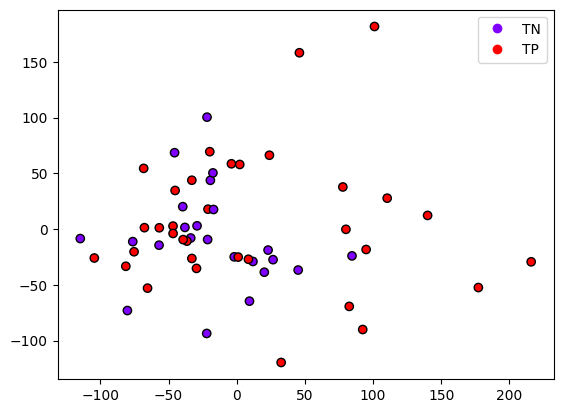

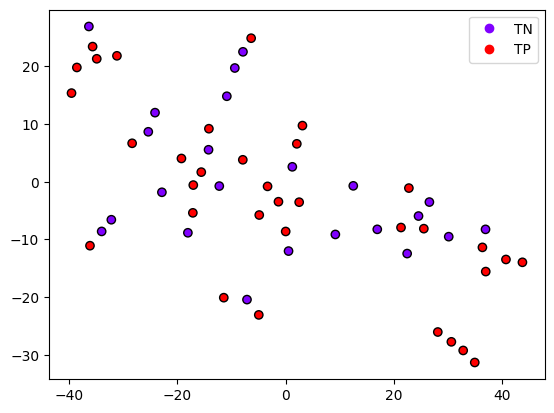


TEST kernel: poly, decision_function_shape: ovr, gamma: 1.0, degree: 3
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


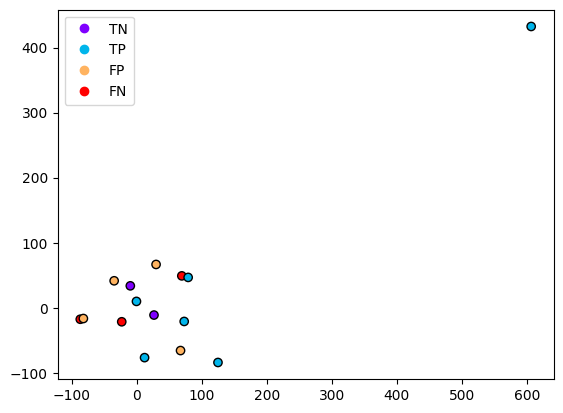

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 1.0, degree: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


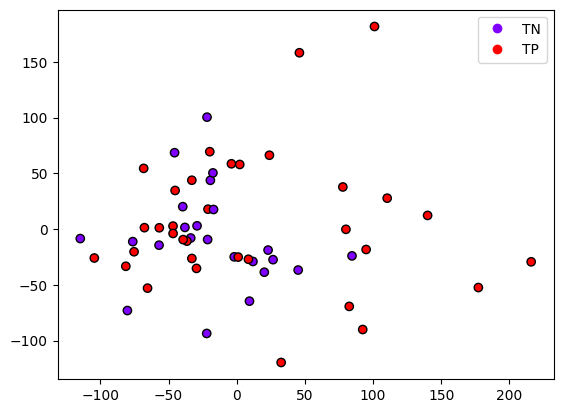

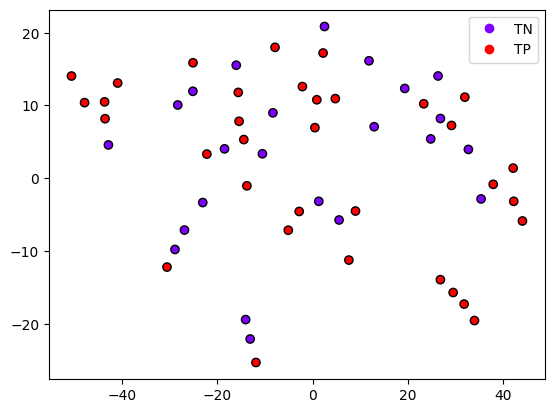


TEST kernel: poly, decision_function_shape: ovr, gamma: 1.0, degree: 5
Accuracy: 0.4666666666666667
Precision: 0.5555555555555556
Recall: 0.5555555555555556
F1 Score: 0.5555555555555556
Confusion Matrix:
 [[2 4]
 [4 5]]


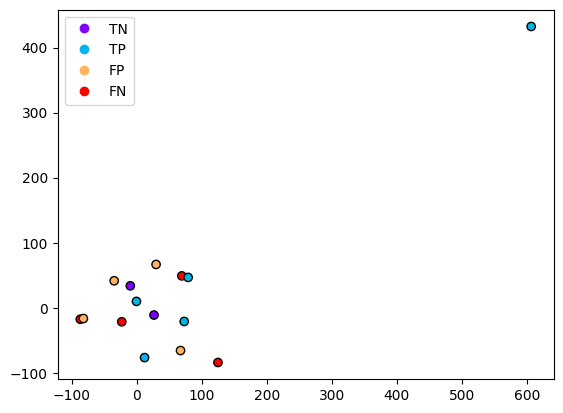

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 1.0, degree: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


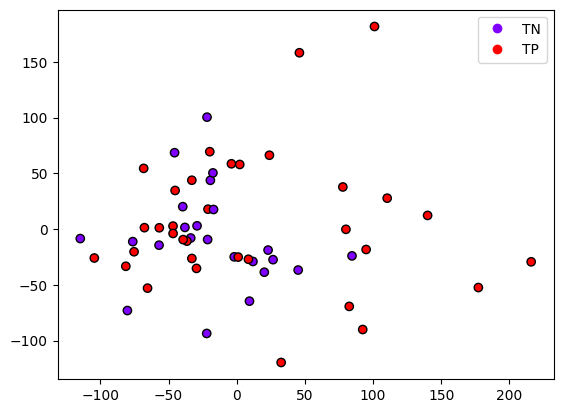

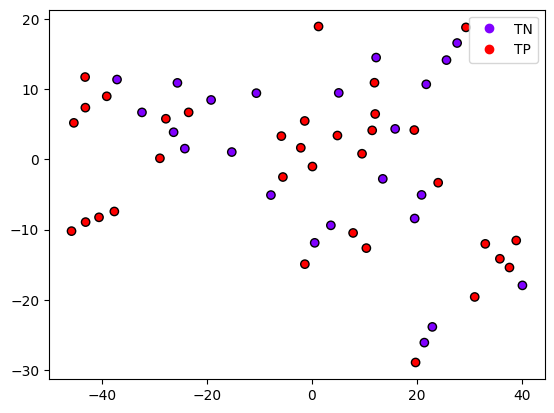


TEST kernel: poly, decision_function_shape: ovr, gamma: 1.0, degree: 10
Incorrect parameters.

TEST kernel: poly, decision_function_shape: ovr, gamma: 2.0, degree: 2
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


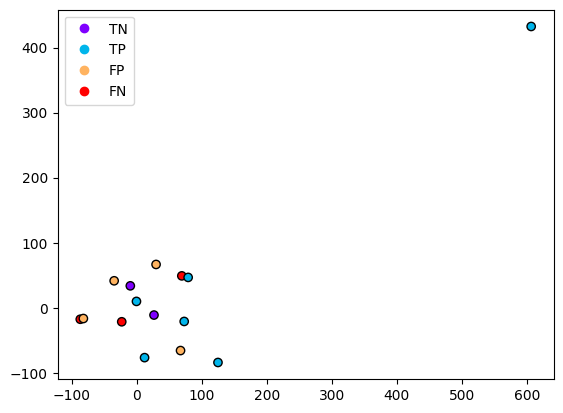

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 2.0, degree: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


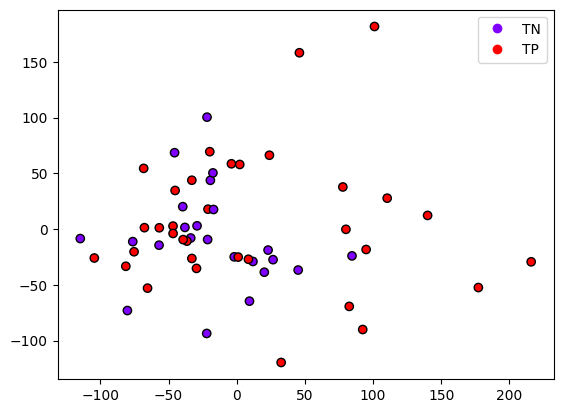

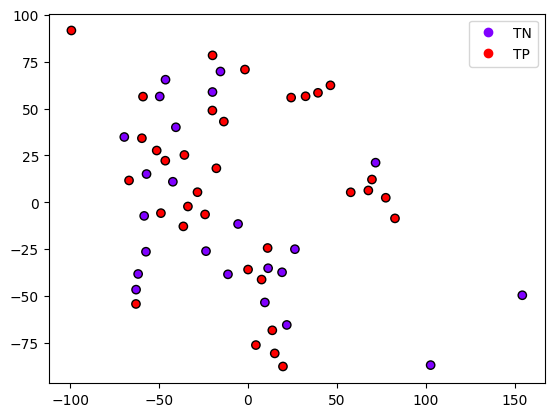


TEST kernel: poly, decision_function_shape: ovr, gamma: 2.0, degree: 3
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


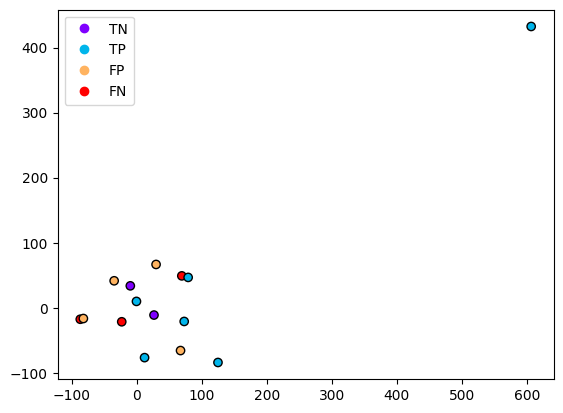

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 2.0, degree: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


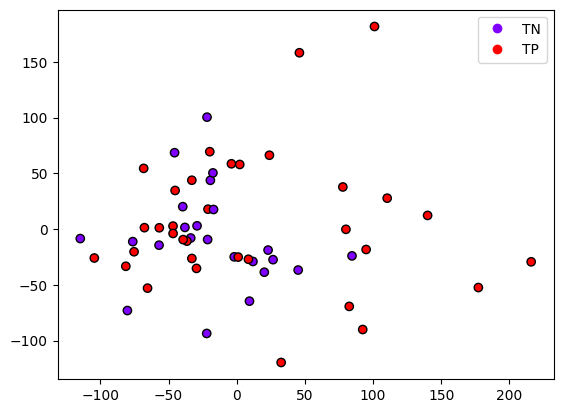

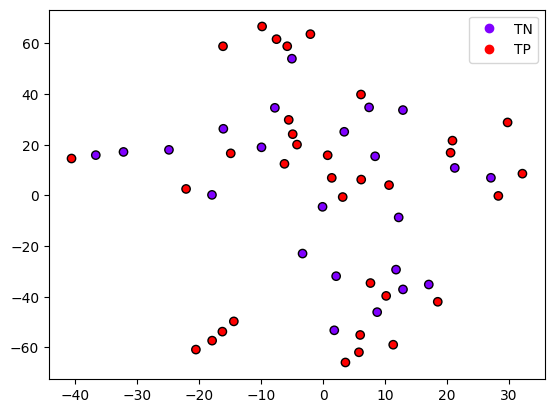


TEST kernel: poly, decision_function_shape: ovr, gamma: 2.0, degree: 5
Accuracy: 0.4666666666666667
Precision: 0.5555555555555556
Recall: 0.5555555555555556
F1 Score: 0.5555555555555556
Confusion Matrix:
 [[2 4]
 [4 5]]


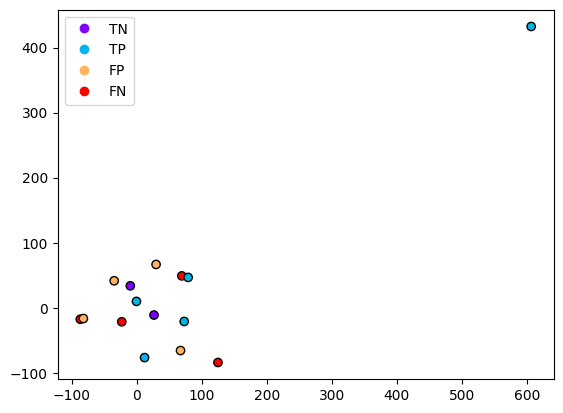

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 2.0, degree: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


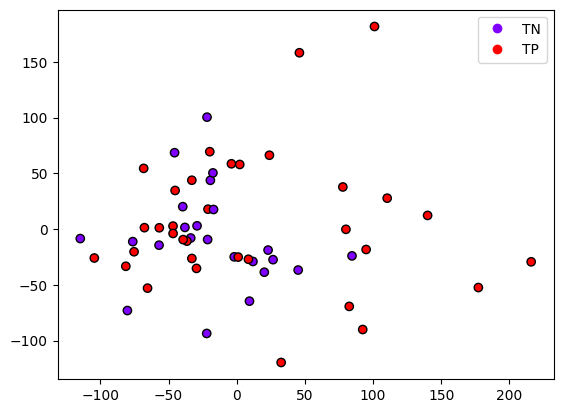

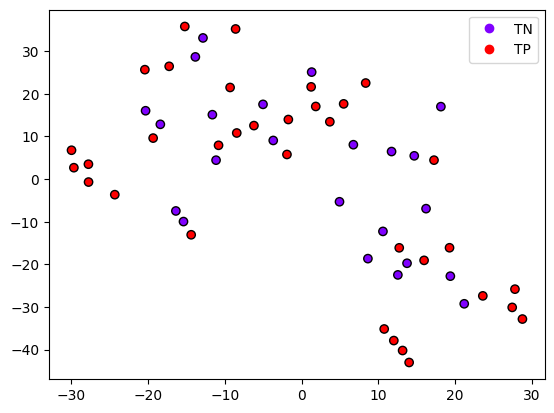


TEST kernel: poly, decision_function_shape: ovr, gamma: 2.0, degree: 10
Incorrect parameters.

TEST kernel: poly, decision_function_shape: ovr, gamma: 10.0, degree: 2
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


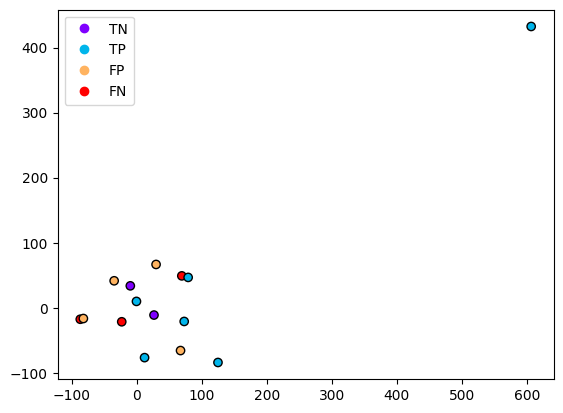

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 10.0, degree: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


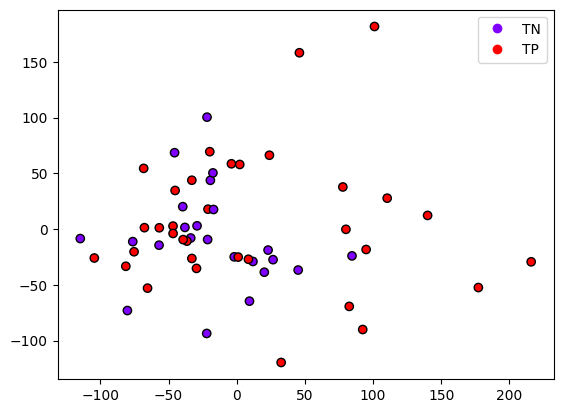

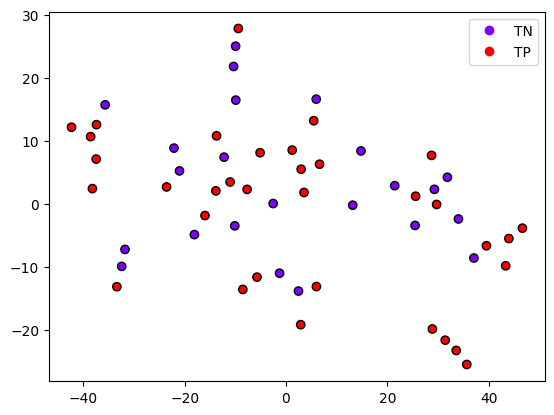


TEST kernel: poly, decision_function_shape: ovr, gamma: 10.0, degree: 3
Accuracy: 0.5333333333333333
Precision: 0.6
Recall: 0.6666666666666666
F1 Score: 0.631578947368421
Confusion Matrix:
 [[2 4]
 [3 6]]


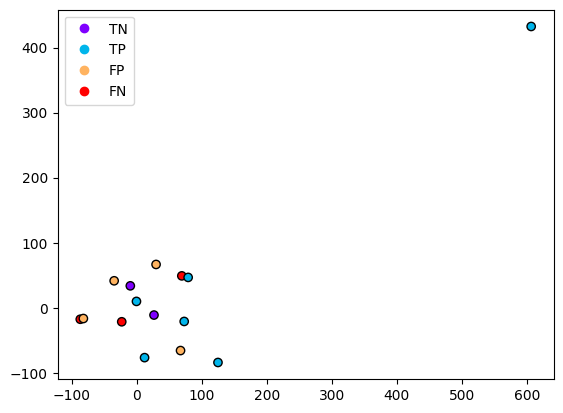

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 10.0, degree: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


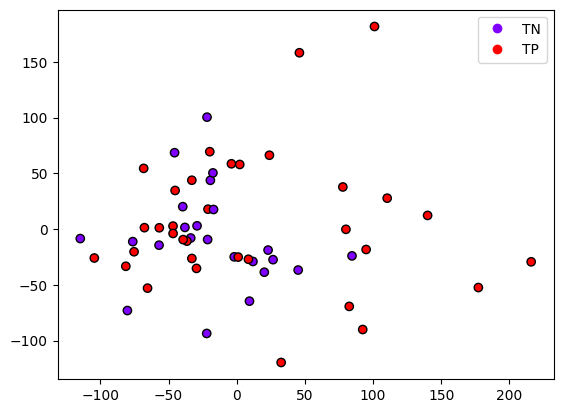

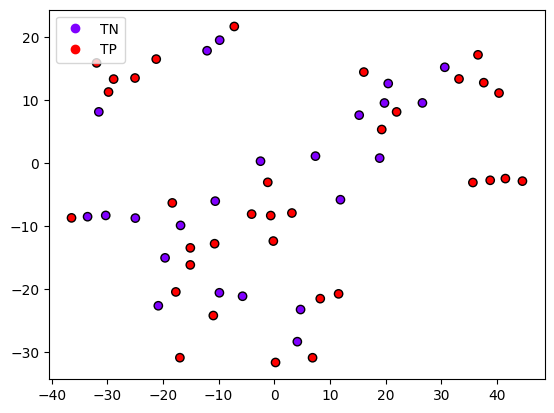


TEST kernel: poly, decision_function_shape: ovr, gamma: 10.0, degree: 5
Accuracy: 0.4666666666666667
Precision: 0.5555555555555556
Recall: 0.5555555555555556
F1 Score: 0.5555555555555556
Confusion Matrix:
 [[2 4]
 [4 5]]


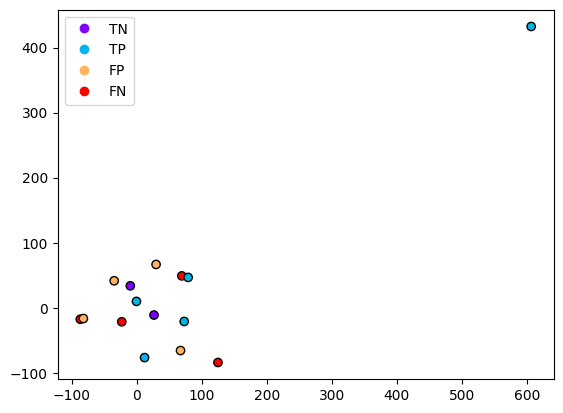

TRAIN kernel: poly, decision_function_shape: ovr, gamma: 10.0, degree: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[23  0]
 [ 0 34]]


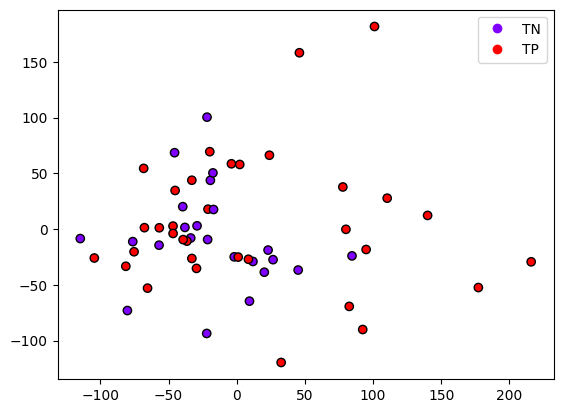

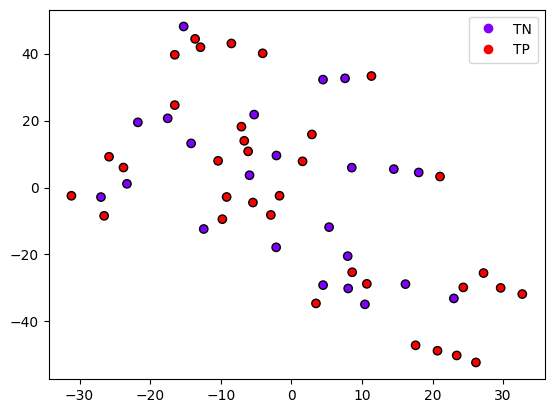


TEST kernel: poly, decision_function_shape: ovr, gamma: 10.0, degree: 10
Incorrect parameters.

TEST kernel: rbf, decision_function_shape: ovo, gamma: scale
Accuracy: 0.7333333333333333
Precision: 1.0
Recall: 0.5555555555555556
F1 Score: 0.7142857142857143
Confusion Matrix:
 [[6 0]
 [4 5]]


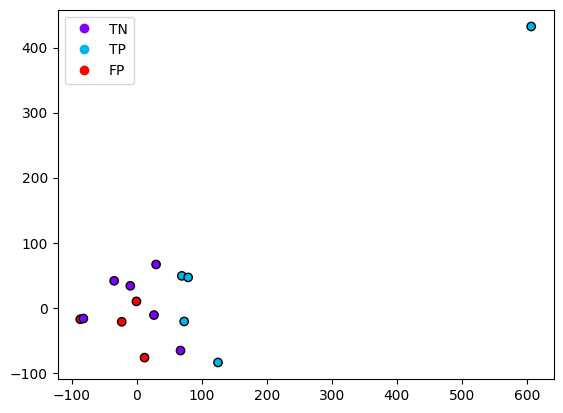

TRAIN kernel: rbf, decision_function_shape: ovo, gamma: scale
Accuracy: 0.5789473684210527
Precision: 1.0
Recall: 0.29411764705882354
F1 Score: 0.45454545454545453
Confusion Matrix:
 [[23  0]
 [24 10]]


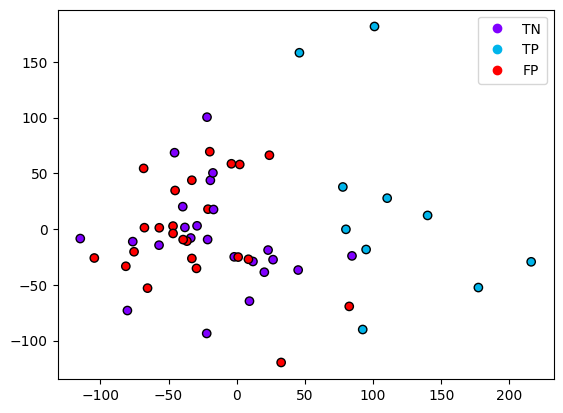

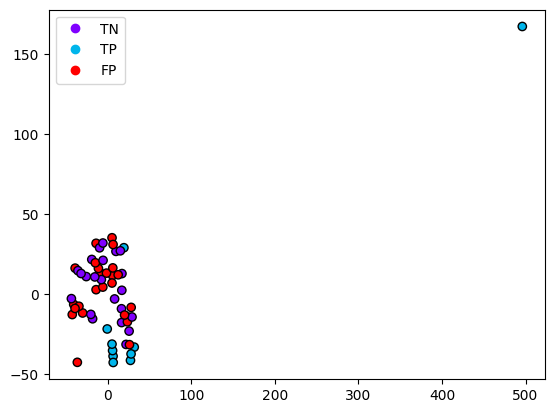


TEST kernel: rbf, decision_function_shape: ovo, gamma: 0.1
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


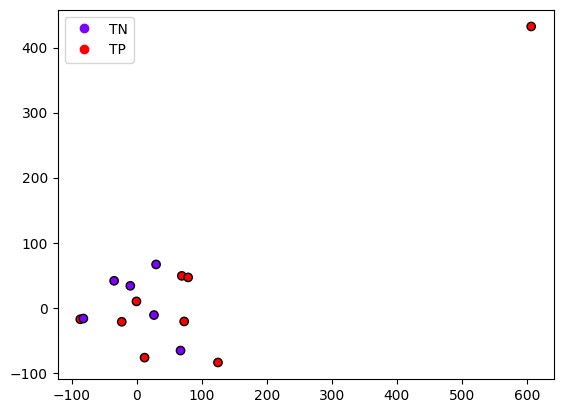

TRAIN kernel: rbf, decision_function_shape: ovo, gamma: 0.1
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


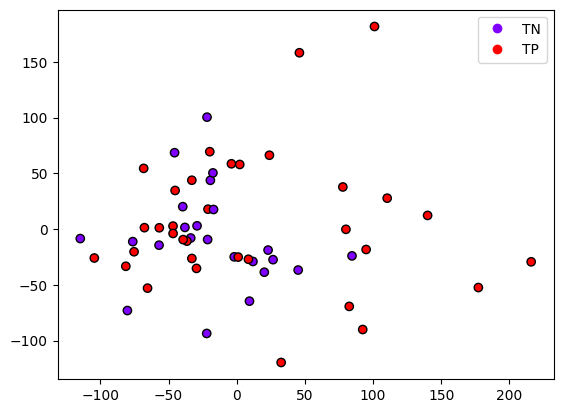

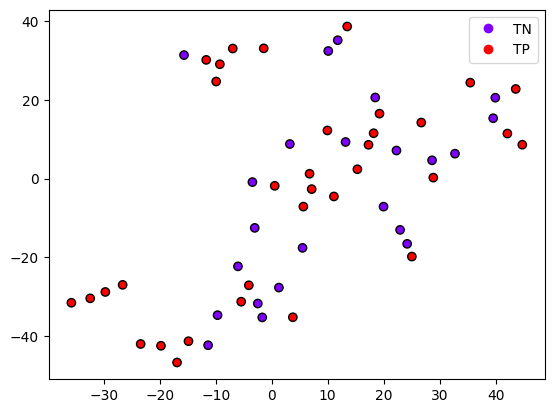


TEST kernel: rbf, decision_function_shape: ovo, gamma: 0.5
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


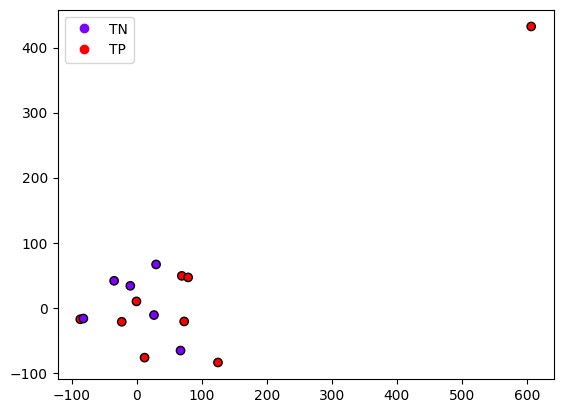

TRAIN kernel: rbf, decision_function_shape: ovo, gamma: 0.5
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


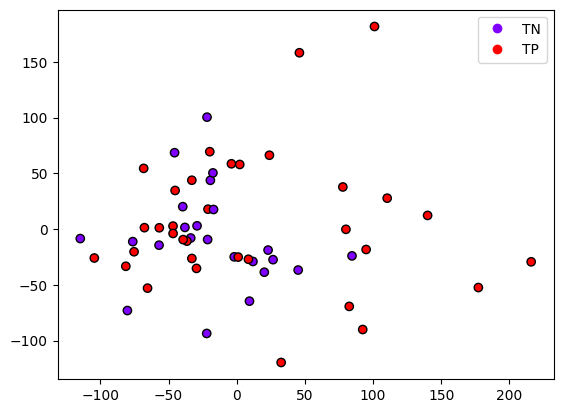

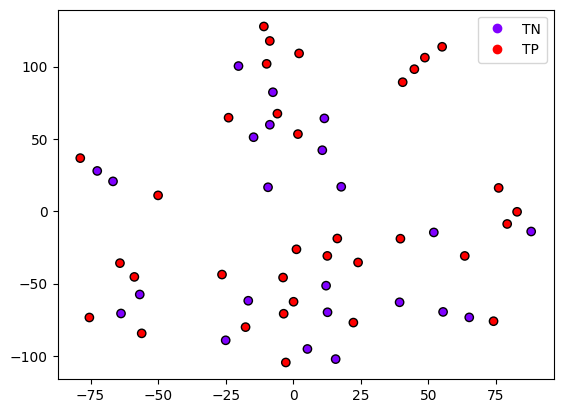


TEST kernel: rbf, decision_function_shape: ovo, gamma: 1.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


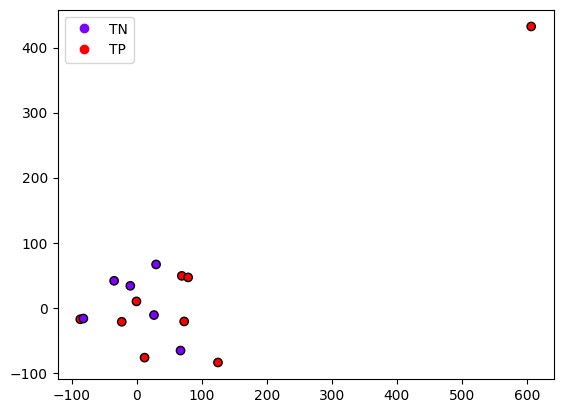

TRAIN kernel: rbf, decision_function_shape: ovo, gamma: 1.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


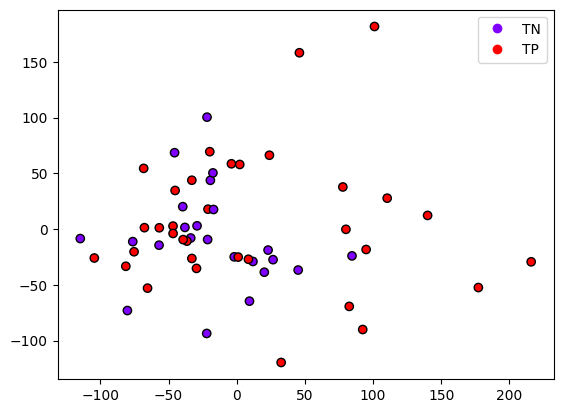

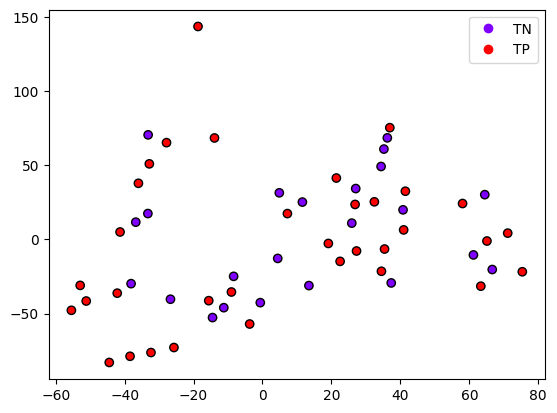


TEST kernel: rbf, decision_function_shape: ovo, gamma: 2.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


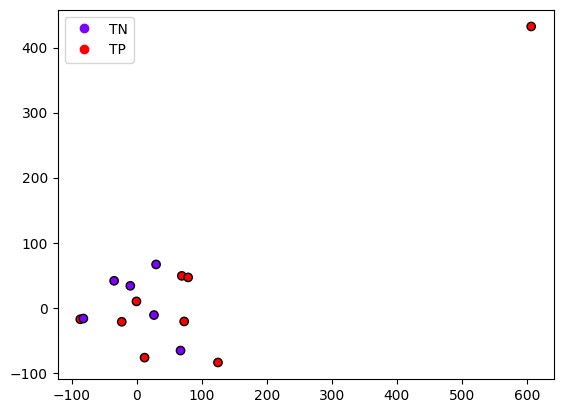

TRAIN kernel: rbf, decision_function_shape: ovo, gamma: 2.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


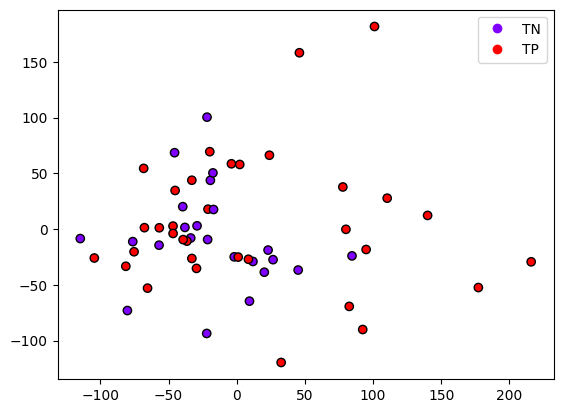

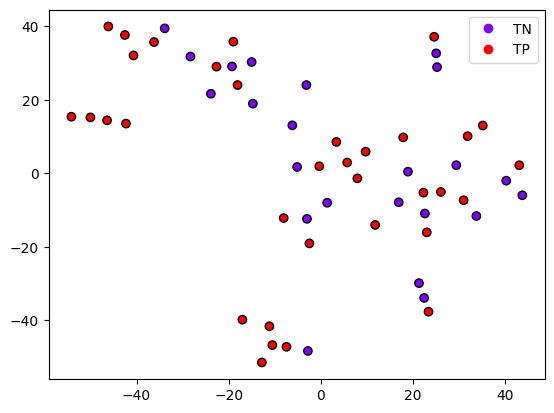


TEST kernel: rbf, decision_function_shape: ovo, gamma: 10.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


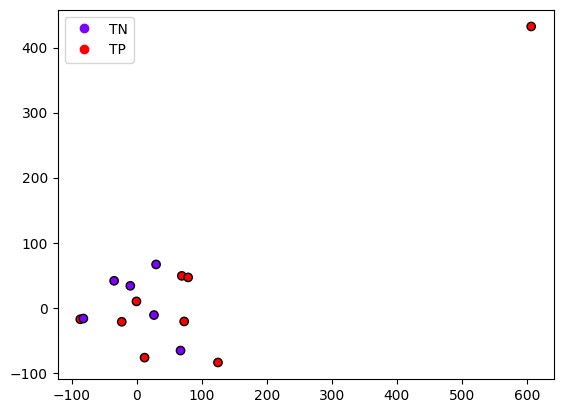

TRAIN kernel: rbf, decision_function_shape: ovo, gamma: 10.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


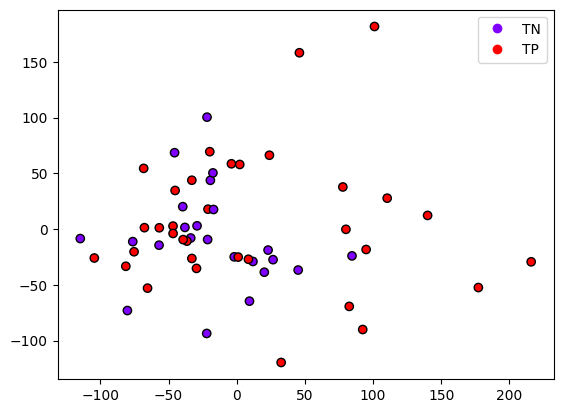

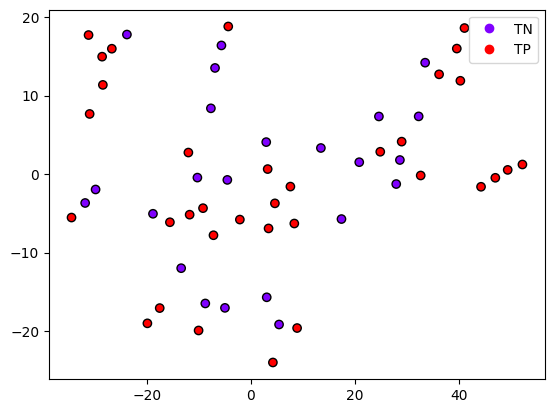


TEST kernel: rbf, decision_function_shape: ovr, gamma: scale
Accuracy: 0.7333333333333333
Precision: 1.0
Recall: 0.5555555555555556
F1 Score: 0.7142857142857143
Confusion Matrix:
 [[6 0]
 [4 5]]


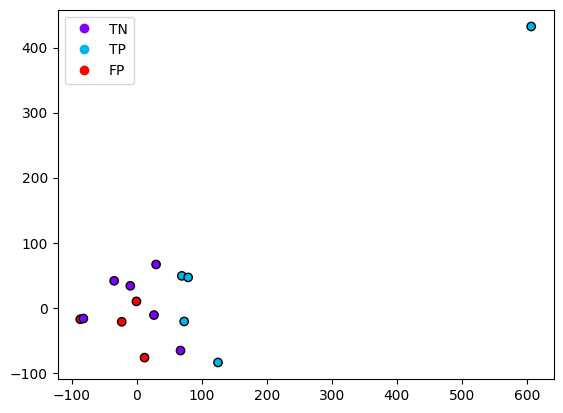

TRAIN kernel: rbf, decision_function_shape: ovr, gamma: scale
Accuracy: 0.5789473684210527
Precision: 1.0
Recall: 0.29411764705882354
F1 Score: 0.45454545454545453
Confusion Matrix:
 [[23  0]
 [24 10]]


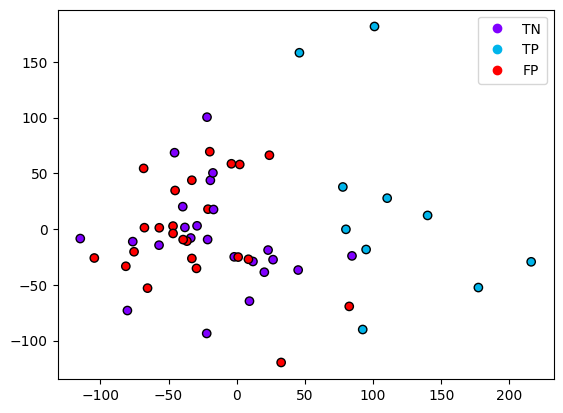

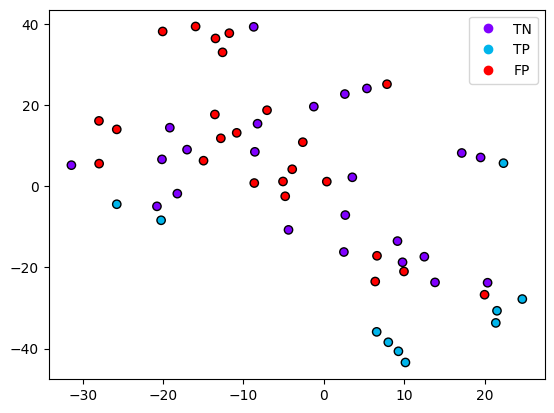


TEST kernel: rbf, decision_function_shape: ovr, gamma: 0.1
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


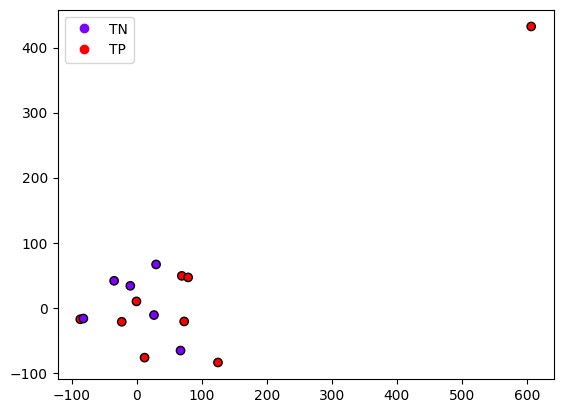

TRAIN kernel: rbf, decision_function_shape: ovr, gamma: 0.1
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


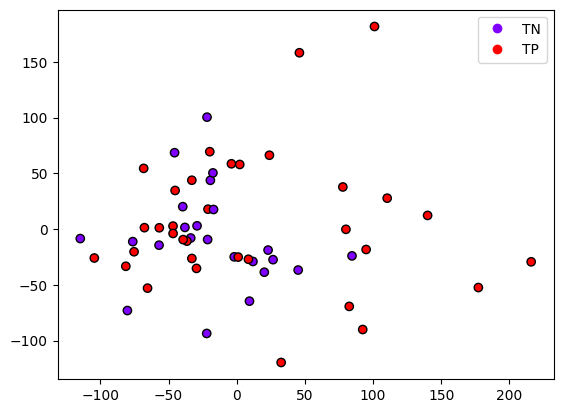

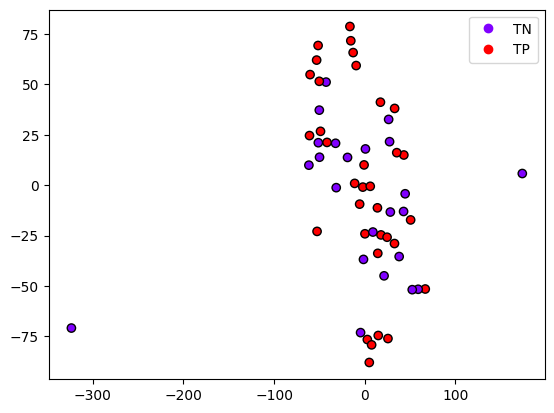


TEST kernel: rbf, decision_function_shape: ovr, gamma: 0.5
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


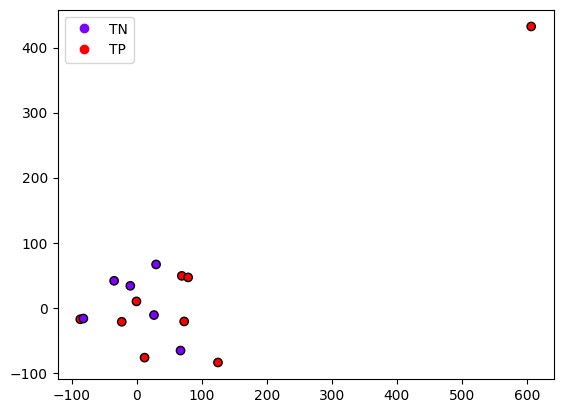

TRAIN kernel: rbf, decision_function_shape: ovr, gamma: 0.5
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


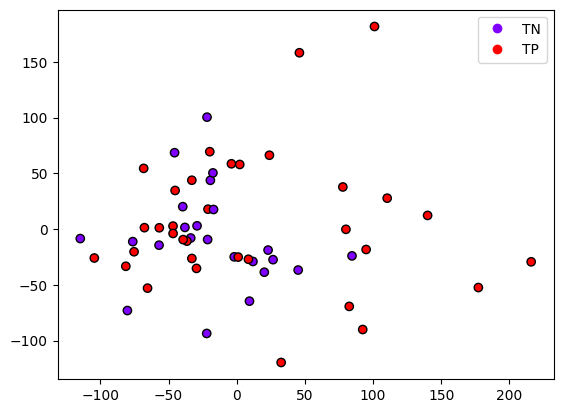

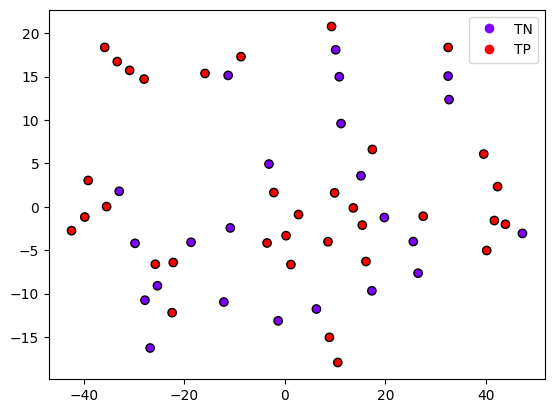


TEST kernel: rbf, decision_function_shape: ovr, gamma: 1.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


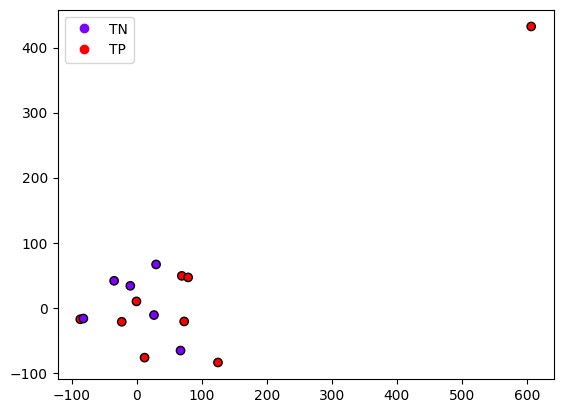

TRAIN kernel: rbf, decision_function_shape: ovr, gamma: 1.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


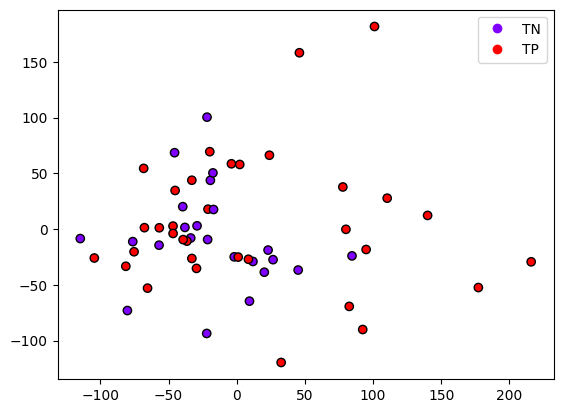

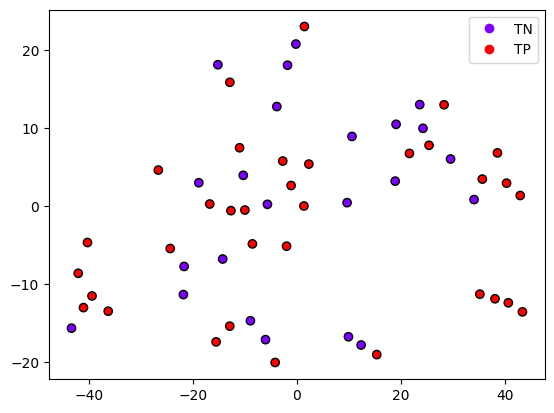


TEST kernel: rbf, decision_function_shape: ovr, gamma: 2.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


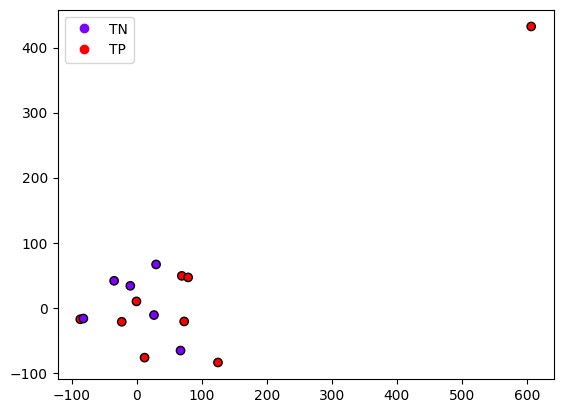

TRAIN kernel: rbf, decision_function_shape: ovr, gamma: 2.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


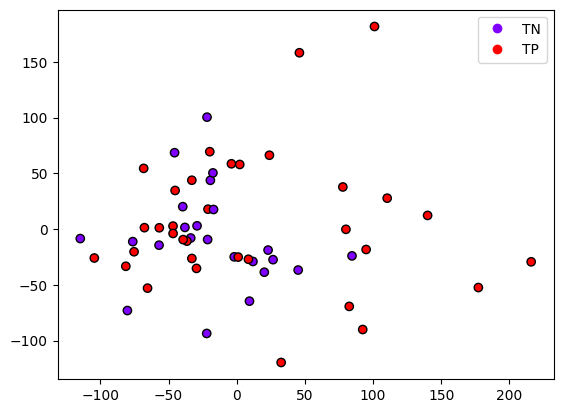

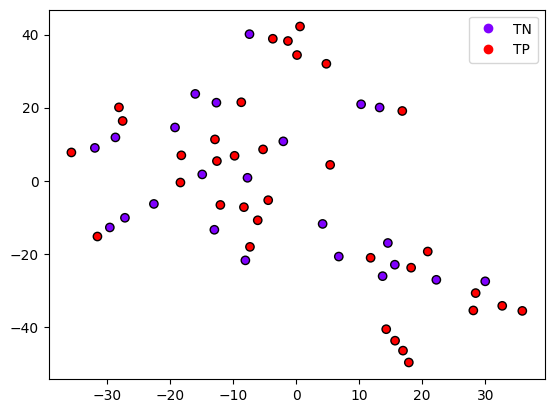


TEST kernel: rbf, decision_function_shape: ovr, gamma: 10.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


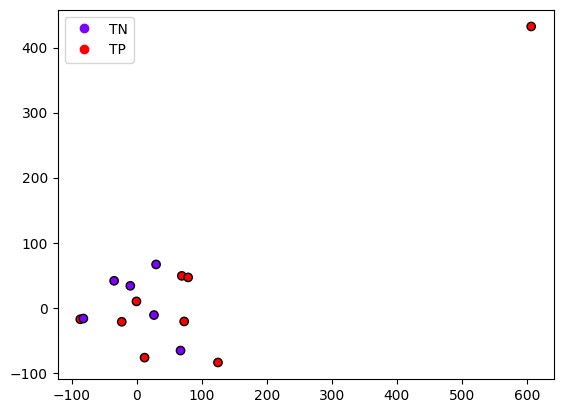

TRAIN kernel: rbf, decision_function_shape: ovr, gamma: 10.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


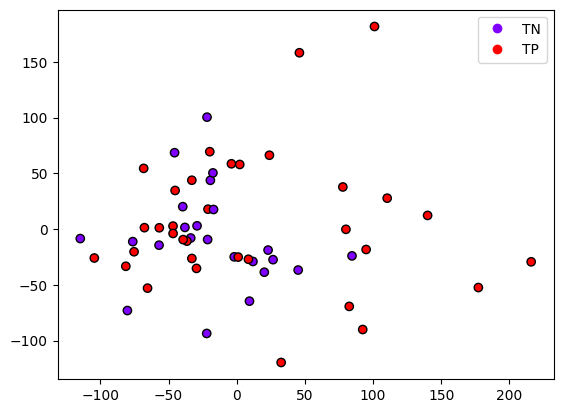

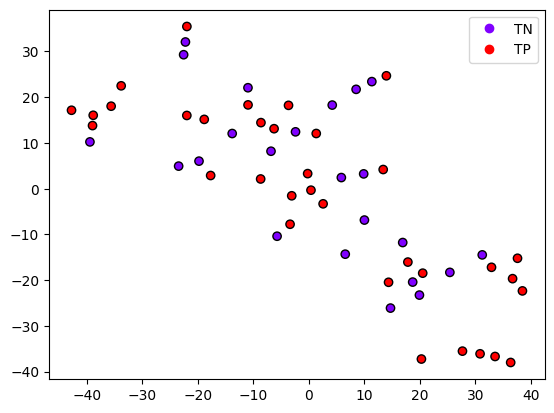


TEST kernel: sigmoid, decision_function_shape: ovo, gamma: scale
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


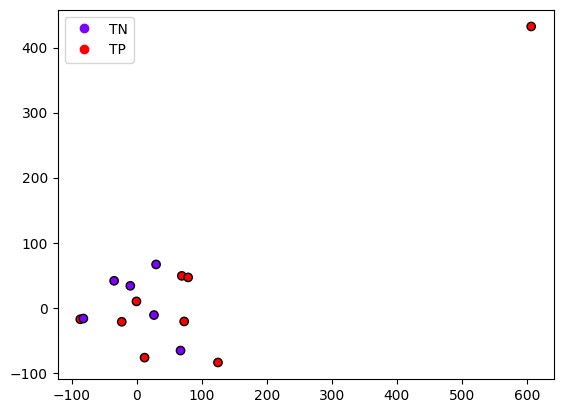

TRAIN kernel: sigmoid, decision_function_shape: ovo, gamma: scale
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


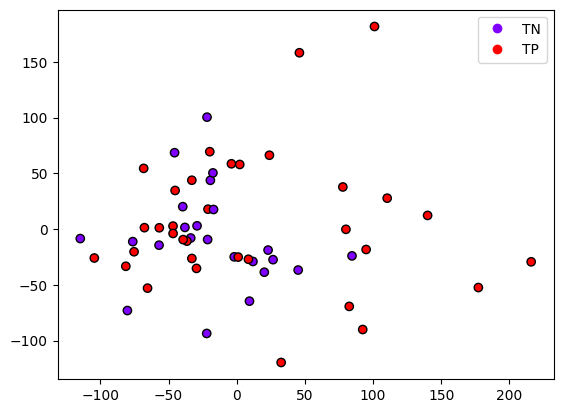

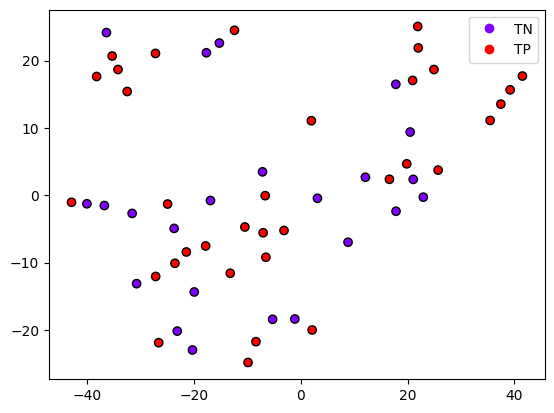


TEST kernel: sigmoid, decision_function_shape: ovo, gamma: 0.1
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


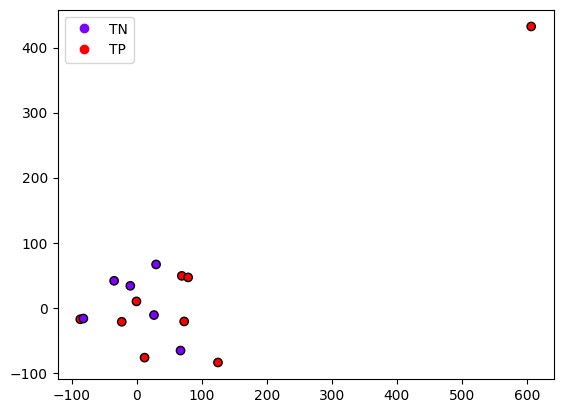

TRAIN kernel: sigmoid, decision_function_shape: ovo, gamma: 0.1
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


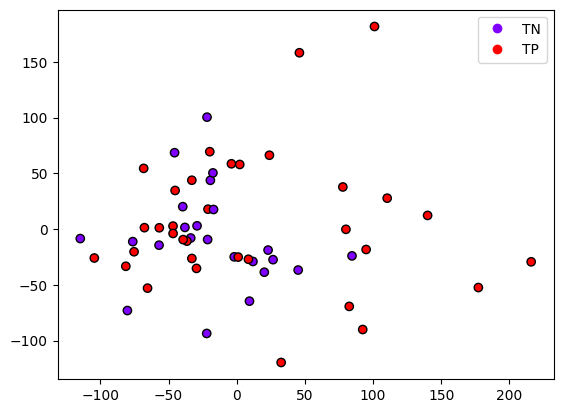

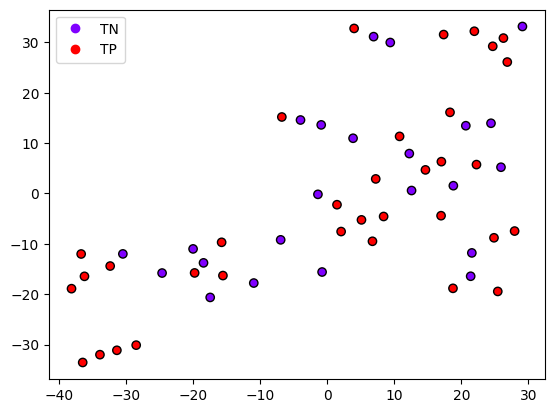


TEST kernel: sigmoid, decision_function_shape: ovo, gamma: 0.5
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


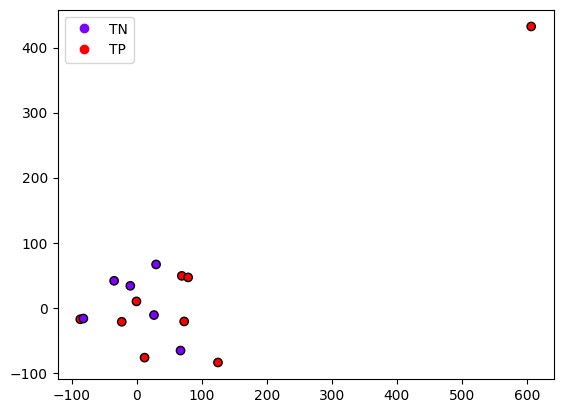

TRAIN kernel: sigmoid, decision_function_shape: ovo, gamma: 0.5
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


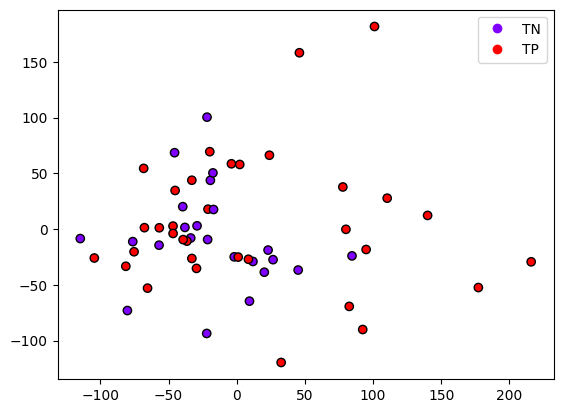

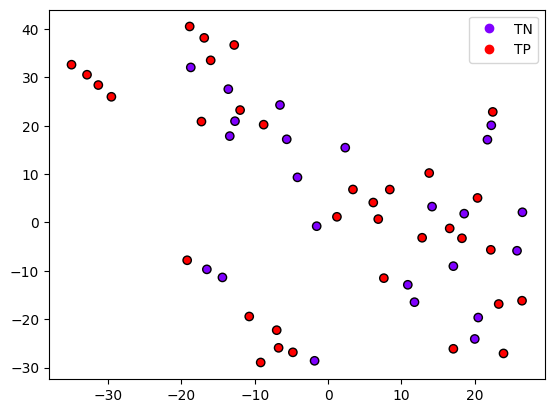


TEST kernel: sigmoid, decision_function_shape: ovo, gamma: 1.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


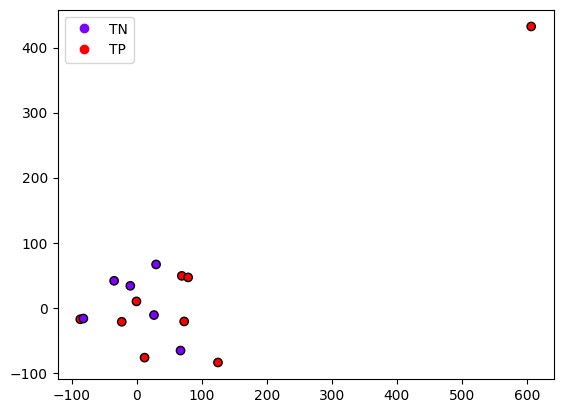

TRAIN kernel: sigmoid, decision_function_shape: ovo, gamma: 1.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


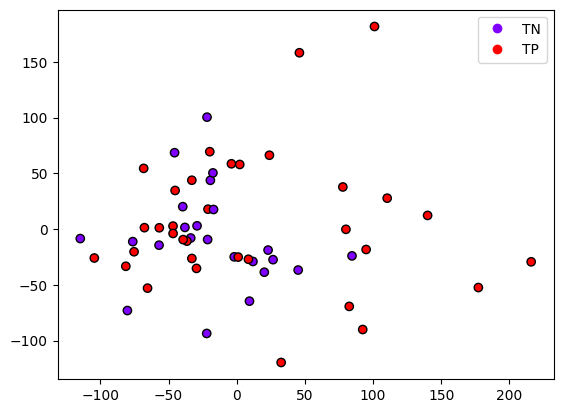

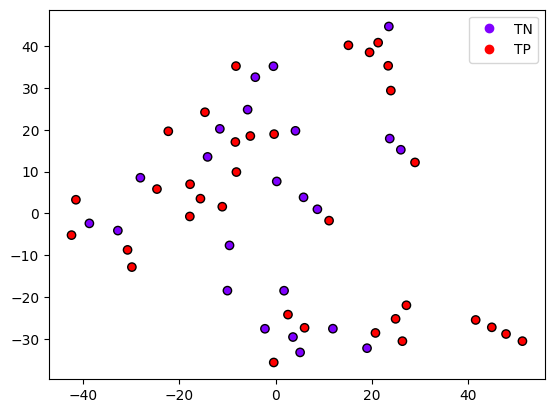


TEST kernel: sigmoid, decision_function_shape: ovo, gamma: 2.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


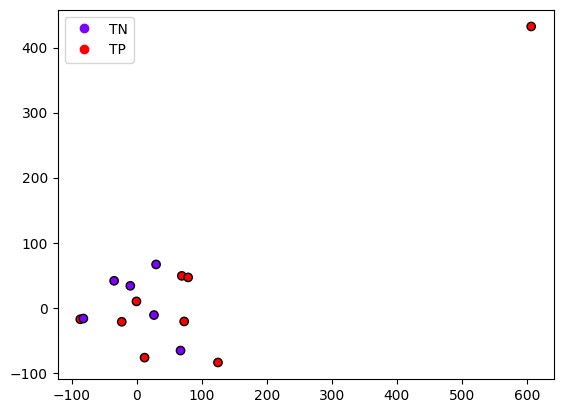

TRAIN kernel: sigmoid, decision_function_shape: ovo, gamma: 2.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


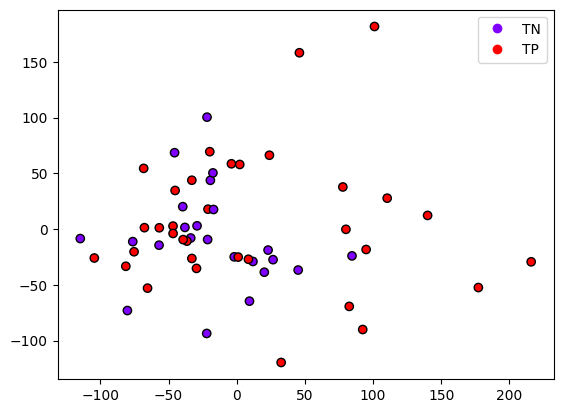

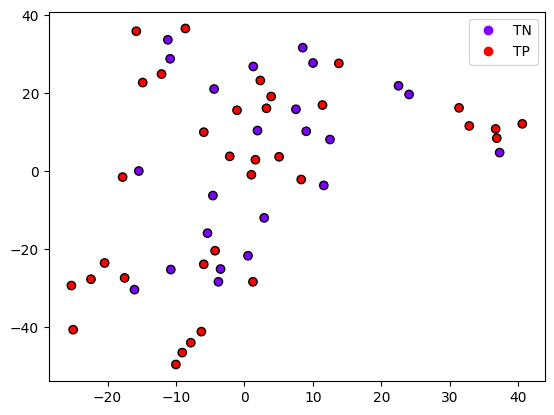


TEST kernel: sigmoid, decision_function_shape: ovo, gamma: 10.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


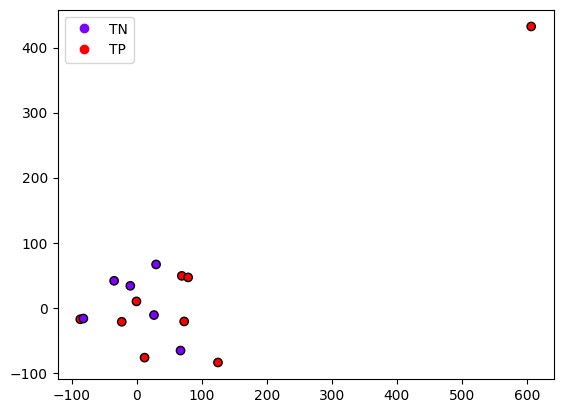

TRAIN kernel: sigmoid, decision_function_shape: ovo, gamma: 10.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


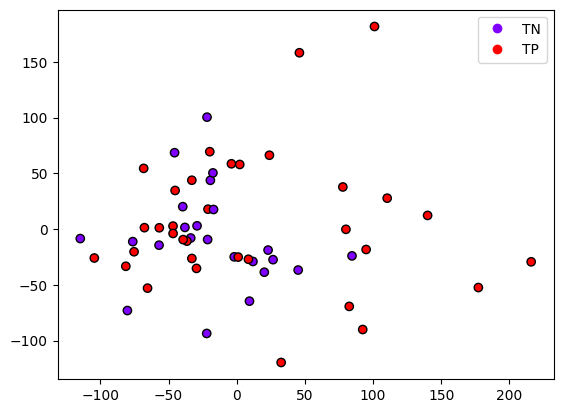

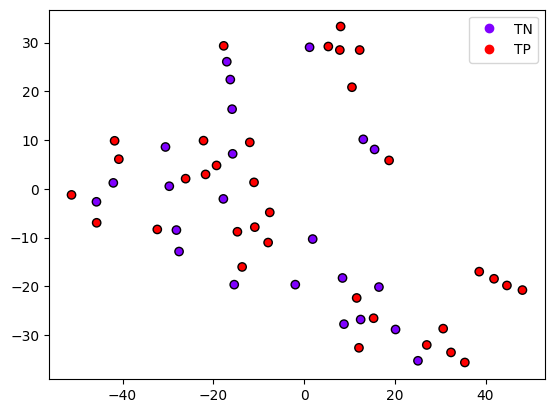


TEST kernel: sigmoid, decision_function_shape: ovr, gamma: scale
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


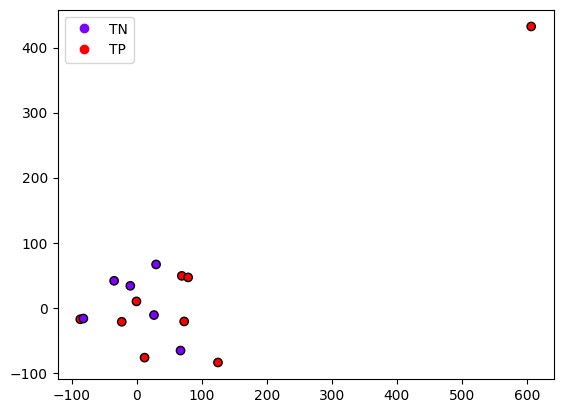

TRAIN kernel: sigmoid, decision_function_shape: ovr, gamma: scale
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


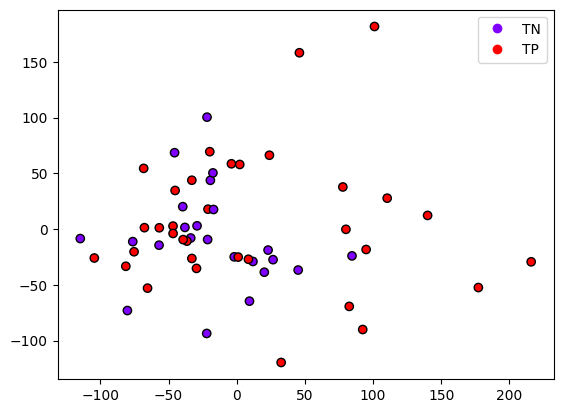

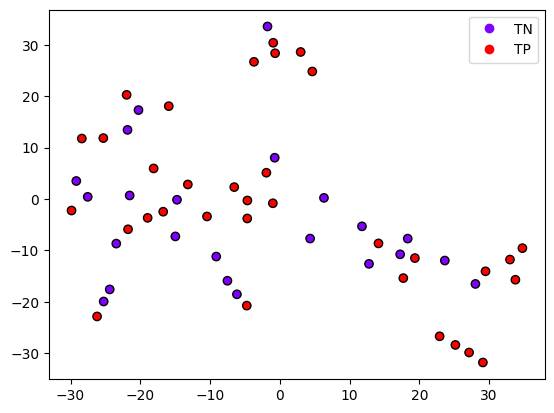


TEST kernel: sigmoid, decision_function_shape: ovr, gamma: 0.1
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


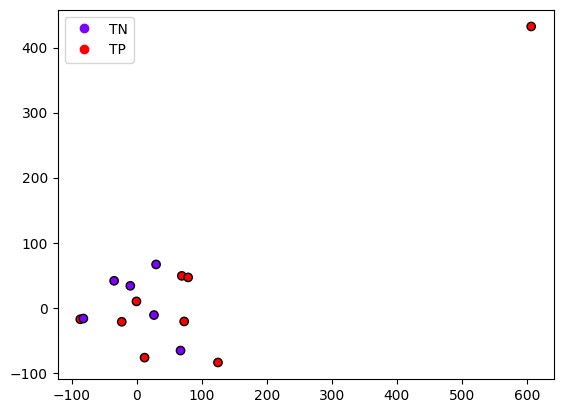

TRAIN kernel: sigmoid, decision_function_shape: ovr, gamma: 0.1
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


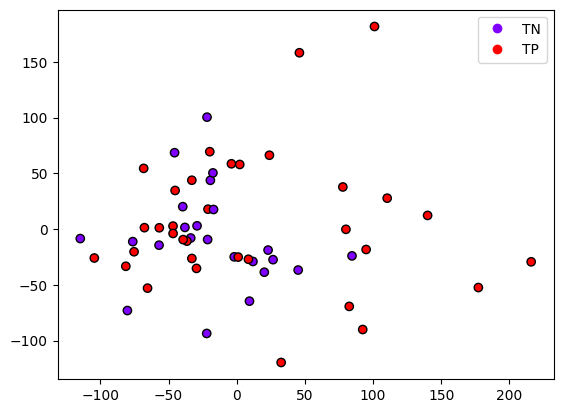

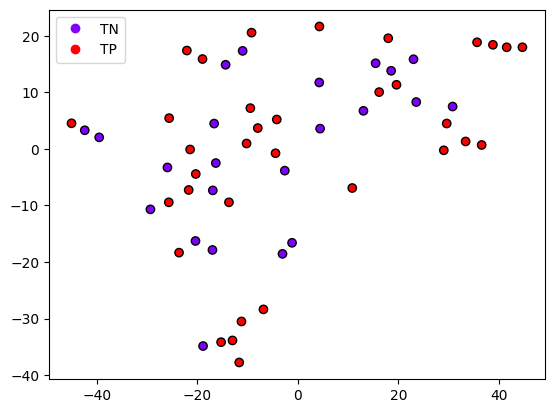


TEST kernel: sigmoid, decision_function_shape: ovr, gamma: 0.5
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


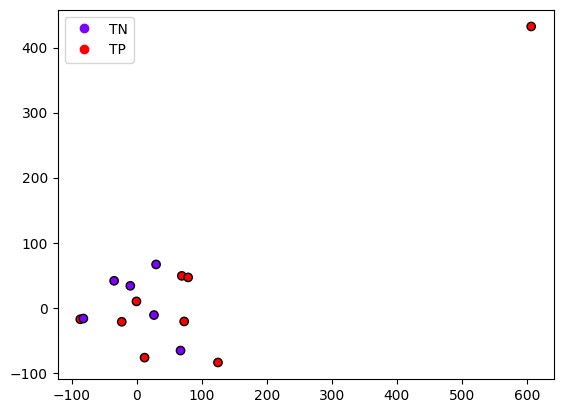

TRAIN kernel: sigmoid, decision_function_shape: ovr, gamma: 0.5
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


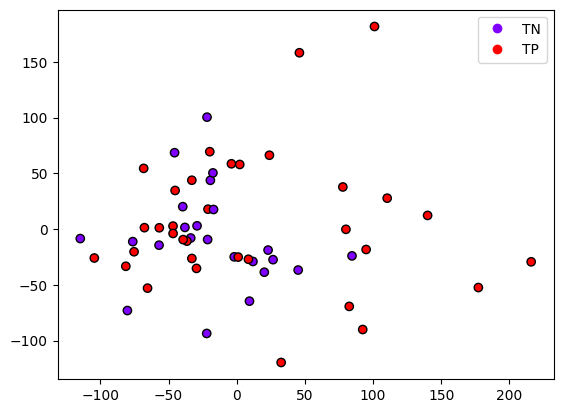

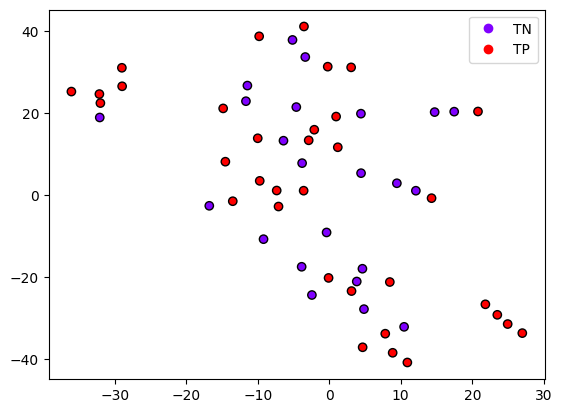


TEST kernel: sigmoid, decision_function_shape: ovr, gamma: 1.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


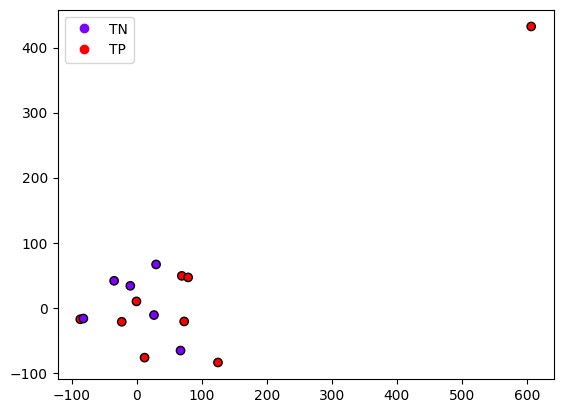

TRAIN kernel: sigmoid, decision_function_shape: ovr, gamma: 1.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


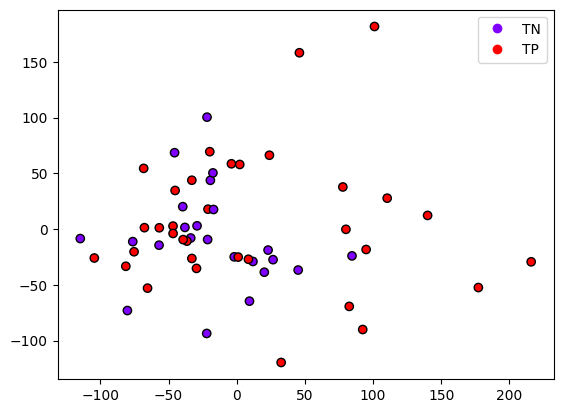

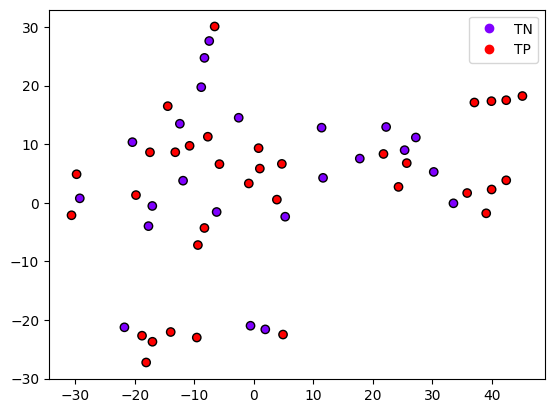


TEST kernel: sigmoid, decision_function_shape: ovr, gamma: 2.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


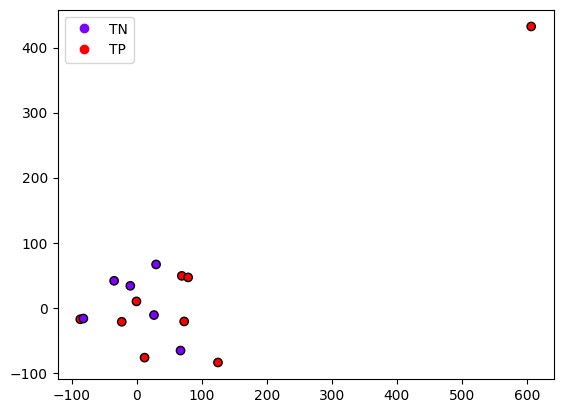

TRAIN kernel: sigmoid, decision_function_shape: ovr, gamma: 2.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


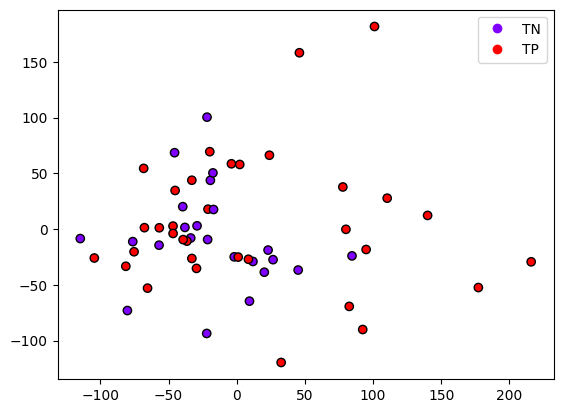

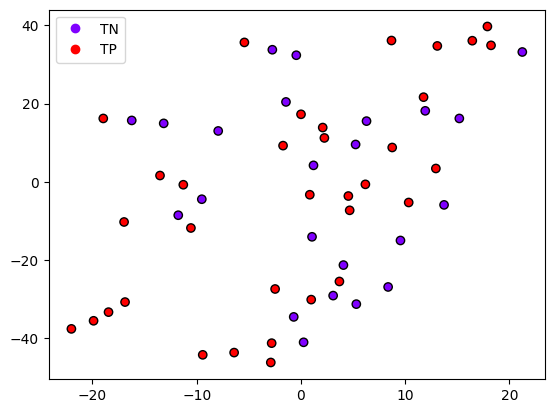


TEST kernel: sigmoid, decision_function_shape: ovr, gamma: 10.0
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[6 0]
 [9 0]]


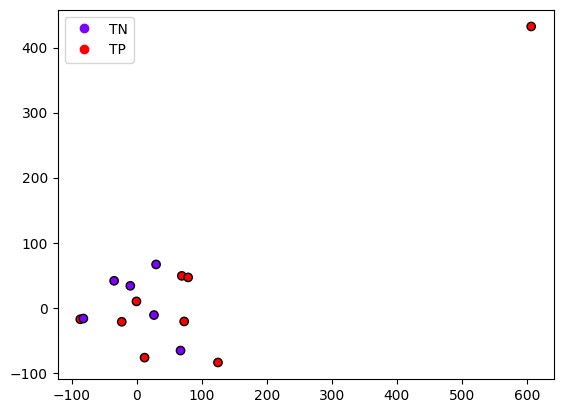

TRAIN kernel: sigmoid, decision_function_shape: ovr, gamma: 10.0
Accuracy: 0.40350877192982454
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
 [[23  0]
 [34  0]]


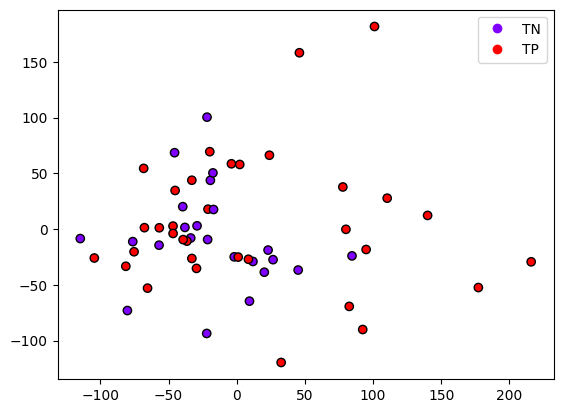

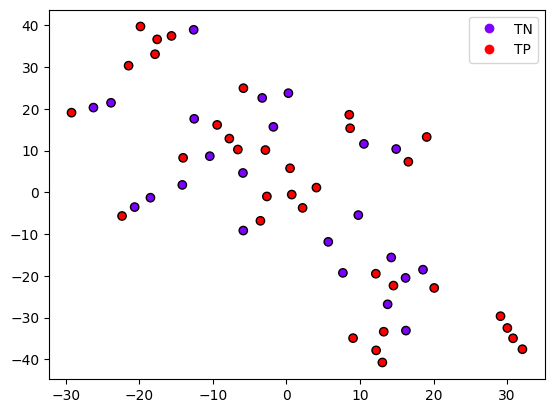

In [75]:
import warnings
warnings.filterwarnings("ignore")

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
decision_function_shape = ['ovo', 'ovr']
gammas = ['scale', 0.1, 0.5, 1.0, 2.0, 10.0]
degrees = [2, 3, 5, 10]
weights = {0: count_2 / (count_1 + count_2), 1: count_1 / (count_1 + count_2)}
pca = PCA(n_components=2)
pca.fit(X_train)
for kernel in kernels:
    for dec in decision_function_shape:
        if kernel == 'linear':
            print(f"\nTEST. kernel: {kernel}, decision_function_shape: {dec}")
            try:
                svm_model = svm.SVC(kernel = kernel, class_weight = weights)
                svm_model.fit(X_train, y_train)
                predict(svm_model, pca, X_test, y_test)
                print(f"TRAIN. kernel: {kernel}, decision_function_shape: {dec}")
                predict(svm_model, pca, X_train, y_train, do_tsne = True)
            except:
                print("Incorrect parameters.")
        elif kernel == 'poly':
            for g in gammas:
                for d in degrees:
                    print(f"\nTEST kernel: {kernel}, decision_function_shape: {dec}, gamma: {g}, degree: {d}")
                    try:
                        svm_model = svm.SVC(kernel = kernel, gamma = g, degree = d, class_weight = weights)
                        svm_model.fit(X_train, y_train)
                        predict(svm_model, pca, X_test, y_test)
                        print(f"TRAIN kernel: {kernel}, decision_function_shape: {dec}, gamma: {g}, degree: {d}")
                        predict(svm_model, pca, X_train, y_train, do_tsne = True)
                    except:
                        print("Incorrect parameters.")
        else:
            for g in gammas:
                  print(f"\nTEST kernel: {kernel}, decision_function_shape: {dec}, gamma: {g}")
                  try:
                      svm_model = svm.SVC(kernel = kernel, gamma = g, class_weight = weights)
                      svm_model.fit(X_train, y_train)
                      predict(svm_model, pca, X_test, y_test)
                      print(f"TRAIN kernel: {kernel}, decision_function_shape: {dec}, gamma: {g}")
                      predict(svm_model, pca, X_train, y_train, do_tsne = True)
                  except:
                      print("Incorrect parameters.")